# Applause analysis for Music Science paper
Extending and adapting the analysis of audience clapping captured during the MusicLab Copenhagen concert experiment for a presentation at CIM 2022.

## Figures and numerical results
- Clap extraction
- Stats on applause rounds
- Stats on Applauders
- Dynamics of synchronous applause (ICI convergence)
- Textures of partial synchrony applause
- Applause as stage responsive collective action (cues for start and stop....)


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.spatial.distance import pdist, squareform
from scipy.signal import butter,filtfilt,find_peaks
from scipy.interpolate import interp1d
import imageio

#pd.options.mode.chained_assignment = None

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

## definitions 

In [4]:
# functions

def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l
  while True:
    if i >= l:
      break
    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)
      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1
    else:
      rms_value = np.nan
    rms_y[i] = rms_value
    i = i + shift
  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y


# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### file access

In [5]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = '/Users/finn/Desktop/Current_Projects/Copen/'

internal_Part = general_loc + 'Participants_internal/'


public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [6]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv',index_col = 0)#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
# partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
Part_Codes = list(MovingParts.index)
# alignedParts = MovingParts
# aligned_Part_Codes = list(alignedParts.Participant_Code.values)

In [7]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')
# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
#Sub_Rels

In [8]:
#claps_folder = './Data/new_indexp/clapping_peaks/'
#claps_folder = '/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/out_claps/clapping_peaks/'
claps_folder = '/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/out_claps/'
os.listdir(claps_folder+'clapping_peaks/')

['Applause_3_speech_2_peaks.csv',
 'Applause_1_entre_1_peaks.csv',
 'Applause_15_finale_peaks.csv',
 'Applause_2_speech_1_peaks.csv',
 'Applause_8_bach_peaks.csv',
 'Applause_10_folk_2_peaks.csv',
 'Applause_11_folk_3_peaks.csv',
 'Applause_9_folk_1_peaks.csv',
 'Applause_4_beethoven_peaks.csv',
 'Applause_6_schnittke_peaks.csv',
 'Applause_12_folk_4_peaks.csv',
 'Applause_13_folk_5_peaks.csv',
 'Applause_5_entre_2_peaks.csv',
 'Applause_7_entre_3_peaks.csv',
 'Applause_14_speech_3_peaks.csv']

In [9]:
Applause_ints=pd.read_csv('./data/Clapping_rounds_stats_ReCut2.csv')

In [10]:
#df_motion.index=(pd.to_datetime(df_motion.index))
applause_times = pd.read_csv('./data/Applause_stage_events_T2.csv',sep=",") #SV alignment for beeps

# need to add datetime
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

applause_times['datetime'] = Synch_time + pd.to_timedelta(applause_times['concert_time'],'s')
#applause_times

# examples claps caught in one round of applause 
Plot a couple of examples of how the claps are detected and how features are extracted per excerpt of clapping.
One example of very steady clapping, one examples of slower intermittingte applase. Plot over same duration of time. 

Use the folk music applause examples to get a resolution readable within a column.

In [11]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [12]:
app_int = 11
partID = 'AEQ087'#'ADQ015'
applause_rnd = 'Applause_11_folk_3'
print(applause_rnd)
df_motion = pd.read_csv(claps_folder + applause_rnd + '_motion.csv',index_col=0)
df_motion.index = df_motion.index/1000
peaks = pd.read_csv(claps_folder +'clapping_peaks/'+ applause_rnd + '_peaks.csv',index_col=0)

#df_motion[partID]

Applause_11_folk_3


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


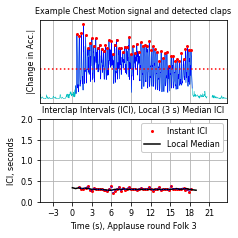

In [13]:
fs = 50
sig = df_motion[partID].copy()
extend_seg = 5 # five seconds was the extension given to the segments being evaluated
extend_ind = 5*fs # segmentation extension, in number of samples
extend = 10 * 0.02 # extending the evaluation windows for peak picking by 0.2 s in samples

seg_len=len(df_motion)

thr=0.01
std_thr = 0.08

rms = rms_signal(sig, fs, 4).dropna().replace(-1,np.nan)
# establish a threshold value for signal rms values where peaks will be counted.
std = np.std(sig)
thr = rms.mean()[0] + std*0.35

# in out pins
# Extends the window for evaluting the peaks by 10 timestamps at both ends (0.2 s)
in_  = max(sig[sig>thr].index.values[0],0) - extend
out_ = min(sig[sig>thr].index.values[-1],sig.index[-1]-extend_seg) + extend
sig.loc[:in_] = np.nan
sig.loc[out_:] = np.nan

# use signal library's find_peaks to pull out peaks in jerk corresponding to clap impacts
peak_index_list = find_peaks(sig.values,distance=10)[0]
#trim peaks based on their height too.
s_plot = sig.iloc[peak_index_list] # get signal values at peaks
s_plot = s_plot[s_plot>thr]

# define region of applause based on acceptable peaks found in motion signal (with 0.2 s extension)
in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
sig.loc[:in_peak] = np.nan
sig.loc[out_peak:] = np.nan

# write to df
sig_peaks = sig.copy()
sig_peaks.loc[:] = np.nan
sig_peaks.loc[s_plot.index] = s_plot.values

# now get ICI
t_interval = 1.5
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)
total_claps = df_OnlyClaps.sum()
# first and last claps as detected
a = df_OnlyClaps.ne(0).idxmax()
first_claps = a-a.median()
a = df_OnlyClaps.iloc[::-1].ne(0).idxmax()
last_claps = a-a.median()

sampletimes = np.arange(0,df_OnlyClaps.index[-1],0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
#         clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps

ici = pd.Series(index = s_plot.index, data = s_plot.index,dtype='float64').diff()

# plot
#fig, ax = plt.subplots(figsize=(7.08661,3.5),tight_layout = True)
# fig, ax = plt.subplots(figsize=(3.34646,3.34646),tight_layout = True)

f, a = plt.subplots(2,1,figsize=(3.34646,3.34646),sharex = True) 
ax = a[0]
# ax.plot(df_motion[partID],'c',sig, 'b-', sig_peaks, 'ro')
ax.plot(df_motion[partID],'c',linewidth=0.5)
ax.plot(sig, 'b-',linewidth = 0.5)
ax.plot(sig_peaks, 'ro',markersize = 2)

ax.plot([sig.index[0],sig.index[-1]],[thr, thr],'r:')
ax.set_yticks([])
ax.tick_params(which='major', width=1.00, length=0)


ax.set_title('Example Chest Motion signal and detected claps' ,fontsize = 8)
ax.set_ylabel('|Change in Acc.|',fontsize = 8)
ax.grid()

ax = a[1]
#ax.plot(ici,'b:',ici,'r.',Clap_Feats.loc[:,partID],'k-')
ax.plot(ici,'ro',markersize = 2,label='Instant ICI')
ax.plot(Clap_Feats.loc[:,partID],'k-',label='Local Median')
ax.plot(ici,'b:',linewidth=1)

ax.set_title('Interclap Intervals (ICI), Local (3 s) Median ICI',fontsize = 8)
ax.set_xlabel('Time (s), Applause round Folk 3')
ax.set_xticks(range(-3,round(sig.index.max()),3))
ax.set_xlim([sig.index.min(),sig.index.max()])
ax.set_ylim([0,2])
ax.set_ylabel('ICI, seconds')
ax.grid()
ax.legend(loc='upper right',bbox_to_anchor=(1,1),framealpha =1)

plt.savefig('./plots/'+partID+'_clapping_demo.eps',bbox_inches = 'tight',backend = 'PS',dpi = 300)
plt.savefig('./plots/'+partID+'_clapping_demo.png',bbox_inches = 'tight',dpi = 300)

plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


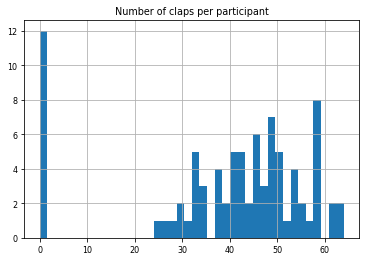

In [14]:
app_int = 5
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

## Clap interval characteristics

The timing of clapping intervals and their onsets an offsets was a great challenge to define. Combined analysis of audio (reliable clock) and video (information from stage). The section combines some of the later reviews fo details into a data frame that can be used to look at timing of applause behaviour against the form documented in these AV recordings. 

Fixed over the christmas break 2022-2023

In [11]:
applause_times.loc[applause_times['Applause_N']==15,:] 
# example of the timing of events during the last round of applause

,concert_time,Applause_N,Event,Actor,Event_Type,Montage_time,Stream_time,Stream_since,Stream_Time_old,early_concert_time,old_concert_time,Concert_audi0_time,datetime
139,8034.1,15,Analysis,Montage,seg,432,10026,258.0,NaN,NaN,8039.6,NaN,2021-10-26 20:02:00.100
140,8041.3,15,Last note,Music,Stage_act,437,10031,5.0,9678.5,8044.10,8044.6,8041.3,2021-10-26 20:02:07.300
141,8042.6,15,Clapping Start,Audience,First_Clap,438,10032,1.0,9679.5,8045.10,8045.6,8042.6,2021-10-26 20:02:08.600
142,8042.6,15,Start to stand,Musicians,Stage_act,438,10032,0.0,NaN,NaN,8045.6,NaN,2021-10-26 20:02:08.600
143,8043.6,15,All standing,Musicians,Stage_act,439,10033,1.0,9680,8045.60,8046.6,NaN,2021-10-26 20:02:09.600
144,8046.6,15,Bow 1,Musicians,Stage_act,442,10036,3.0,9684,8049.60,8049.6,NaN,2021-10-26 20:02:12.600
145,8053.6,15,Bow 2,Musicians,Stage_act,449,10043,7.0,9691,8056.60,8056.6,NaN,2021-10-26 20:02:19.600
146,8059.6,15,Turn to de-equip,Musicians,Stage_act,455,10049,6.0,NaN,NaN,8062.6,NaN,2021-10-26 20:02:25.600
147,8061.6,15,Claps synching,Audience,Audience_sync,458,10052,3.0,9697.7,8063.30,8065.6,8061.6,2021-10-26 20:02:27.600
148,8061.6,15,De-equiping,Musicians,Stage_act,458,10052,0.0,NaN,NaN,8065.6,NaN,2021-10-26 20:02:27.600


In [12]:
cue_start = [1,10,18,24,36,42,60,68,78,88, 99,111,123,134,140]
cue_end =   [4,13,19,29,38,53,62,73,84,93,104,116,127,137,158]
stage_end = [8,14,19,32,38,57,64,76,86,97,107,119,131,137,159]
# applause_times.loc[applause_times['Event_Type'].isin(['Stage_act']),:] 


In [15]:
Ons = applause_times.loc[applause_times['Event_Type'] == 'First_Clap',:]
Offs = applause_times.loc[applause_times['Event_Type'] == 'Last_Clap',:]
Applause_ints = pd.DataFrame()
Applause_ints['start_time'] = Ons['concert_time'].values
Applause_ints['end_time'] = Offs['concert_time'].values
Applause_ints['duration'] = Offs['concert_time'].values-Ons['concert_time'].values
Applause_ints['start_datetime'] = Ons['datetime'].values
Applause_ints['Type'] = ['Entrance','Speech','Speech','Music','Entrance','Music','Entrance','Music','Music','Music','Music','Music','Music','Speech','Music']
Applause_ints['Type_M'] = ['Other','Other','Other','Music','Other','Music','Other','Music','Music','Music','Music','Music','Music','Other','Music']
Applause_ints['Texture'] = ['Independent','Independent','Independent','Mixed','Independent','Mixed','Independent','Independent','Independent','Independent','Independent','Independent','Independent','Independent','Synched']
Applause_ints['event_tag'] = ['Entrance 1','Speech 1','Speech 2','Beethoven','Entrance 2','Schnittke','Entrance 3','Bach','Folk 1','Folk 2','Folk 3','Folk 4','Folk 5','Speech 3','Finale']

Applause_ints['Applause_N']=applause_times.loc[applause_times['Event_Type']=='seg','Applause_N'].values#()

Applause_ints['cue_start_time'] = applause_times.loc[cue_start,'concert_time'].values
Applause_ints['cue_start_type'] = applause_times.loc[cue_start,'Event'].values
Applause_ints['cue_time2start'] = Applause_ints['start_time'] - Applause_ints['cue_start_time']
Applause_ints['cue_end_time'] = applause_times.loc[cue_end,'concert_time'].values
Applause_ints['cue_end_type'] = applause_times.loc[cue_end,'Event'].values
Applause_ints['cue_time2end'] = Applause_ints['end_time'] - Applause_ints['cue_end_time']

Applause_ints['stage_next_time'] = applause_times.loc[stage_end,'concert_time'].values
Applause_ints['stage_next_type'] = applause_times.loc[stage_end,'Event'].values
Applause_ints['stage_next_time2'] = Applause_ints['end_time'] - Applause_ints['stage_next_time']

Applause_ints['files'] = ['Applause_1_entre_1_peaks.csv',
 'Applause_2_speech_1_peaks.csv',
 'Applause_3_speech_2_peaks.csv',
 'Applause_4_beethoven_peaks.csv',
 'Applause_5_entre_2_peaks.csv',
 'Applause_6_schnittke_peaks.csv',
 'Applause_7_entre_3_peaks.csv',
 'Applause_8_bach_peaks.csv',
 'Applause_9_folk_1_peaks.csv',
 'Applause_10_folk_2_peaks.csv',
 'Applause_11_folk_3_peaks.csv',
 'Applause_12_folk_4_peaks.csv',
 'Applause_13_folk_5_peaks.csv',
 'Applause_14_speech_3_peaks.csv',
 'Applause_15_finale_peaks.csv']

Applause_ints['links'] = ['https://youtu.be/S4UVJybA6ZQ?t=1294',
'https://youtu.be/S4UVJybA6ZQ?t=1430',
'https://youtu.be/S4UVJybA6ZQ?t=2018',
'https://youtu.be/S4UVJybA6ZQ?t=3596',
'https://youtu.be/S4UVJybA6ZQ?t=3990',
'https://youtu.be/S4UVJybA6ZQ?t=5251',
'https://youtu.be/S4UVJybA6ZQ?t=6990',
'https://youtu.be/S4UVJybA6ZQ?t=7996',
'https://youtu.be/S4UVJybA6ZQ?t=8741',
'https://youtu.be/S4UVJybA6ZQ?t=8918',
'https://youtu.be/S4UVJybA6ZQ?t=9154',
'https://youtu.be/S4UVJybA6ZQ?t=9509',
'https://youtu.be/S4UVJybA6ZQ?t=9731',
'https://youtu.be/S4UVJybA6ZQ?t=9753',
'https://youtu.be/S4UVJybA6ZQ?t=10026']
Applause_ints['Links_time(s)'] = [1294,1430,2018,3596,3990,5251,6990,7996,8741,8918,9154,9509,9731,9753,10026]
Applause_ints['Vid_times'] = [0,25,41,57,107,127,212,237,273,303,329,355,390,412,432]

Applause_ints['Links_ctime(s)'] = Applause_ints['Links_time(s)'] - 1986 #Beeps offset to concert time
# NOTE: Cue to End needs revising, as that is not chronologically viable. 
Applause_ints

,start_time,end_time,duration,start_datetime,Type,Type_M,Texture,event_tag,Applause_N,cue_start_time,...,cue_end_type,cue_time2end,stage_next_time,stage_next_type,stage_next_time2,files,links,Links_time(s),Vid_times,Links_ctime(s)
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entrance,Other,Independent,Entrance 1,1,-692.20,...,Vn toward mic,3.10,-673.1,Start to speak,-1.0,Applause_1_entre_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=1294,1294,0,-692
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech,Other,Independent,Speech 1,2,-556.10,...,MC at Mic,3.30,-550.6,MC starts talking,2.0,Applause_2_speech_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=1430,1430,25,-556
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech,Other,Independent,Speech 2,3,31.00,...,Vn pick up instrument,2.10,38.0,Vn pick up instrument,2.1,Applause_3_speech_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=2018,2018,41,32
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Music,Music,Mixed,Beethoven,4,1609.60,...,Start to leave,25.50,1642.2,MC talking,9.9,Applause_4_beethoven_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=3596,3596,57,1610
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entrance,Other,Independent,Entrance 2,5,2004.80,...,Begin to sit,3.30,2012.8,Begin to sit,3.3,Applause_5_entre_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=3990,3990,107,2004
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Music,Music,Mixed,Schnittke,6,3278.90,...,Start to leave,6.10,3344.7,MC at mic,-2.0,Applause_6_schnittke_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=5251,5251,127,3265
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entrance,Other,Independent,Entrance 3,7,5001.92,...,Start to sit,4.58,5019.9,MC talking,-0.4,Applause_7_entre_3_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=6990,6990,212,5004
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Music,Music,Independent,Bach,8,6017.20,...,MC towards mic,5.00,6041.1,MC talking,1.0,Applause_8_bach_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=7996,7996,237,6010
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Music,Music,Independent,Folk 1,9,6756.90,...,Vn ready to play,2.10,6776.7,Vnplays,-0.5,Applause_9_folk_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=8741,8741,273,6755
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Music,Music,Independent,Folk 2,10,6931.90,...,Vn towards mic,12.20,6952.9,Vn speaks,-0.3,Applause_10_folk_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=8918,8918,303,6932


In [16]:
Applause_ints.to_csv('./data/Clapping_rounds_4.csv')


In [17]:
1652.1 - 27*60

32.09999999999991

In [18]:
Applause_ints.loc[:,['start_time', 'end_time', 'duration', 'start_datetime', 
       'event_tag', 'Applause_N', 'files','Links_time(s)', 'Vid_times',
       'Links_ctime(s)']]

,start_time,end_time,duration,start_datetime,event_tag,Applause_N,files,Links_time(s),Vid_times,Links_ctime(s)
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entrance 1,1,Applause_1_entre_1_peaks.csv,1294,0,-692
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech 1,2,Applause_2_speech_1_peaks.csv,1430,25,-556
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech 2,3,Applause_3_speech_2_peaks.csv,2018,41,32
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Beethoven,4,Applause_4_beethoven_peaks.csv,3596,57,1610
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entrance 2,5,Applause_5_entre_2_peaks.csv,3990,107,2004
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Schnittke,6,Applause_6_schnittke_peaks.csv,5251,127,3265
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entrance 3,7,Applause_7_entre_3_peaks.csv,6990,212,5004
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Bach,8,Applause_8_bach_peaks.csv,7996,237,6010
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Folk 1,9,Applause_9_folk_1_peaks.csv,8741,273,6755
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Folk 2,10,Applause_10_folk_2_peaks.csv,8918,303,6932


In [19]:
c = 'Entrance'
Applause_ints.loc[Applause_ints['Type']==c,['Applause_N','cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_type', 'stage_next_time2']]

,Applause_N,cue_start_time,cue_start_type,cue_time2start,cue_end_time,cue_end_type,cue_time2end,stage_next_type,stage_next_time2
0,1,-692.20,Enter hall,1.0,-677.20,Vn toward mic,3.10,Start to speak,-1.0
4,5,2004.80,Enter hall,0.0,2012.80,Begin to sit,3.30,Begin to sit,3.3
6,7,5001.92,Enter hall,0.0,5014.92,Start to sit,4.58,MC talking,-0.4


Type 
Instances
Duration Mean (STD)
Start cue type 
End cue type

Entrance
3

Musicians enter hall
Musicians sit down



In [22]:
c = 'Speech'
Applause_ints.loc[Applause_ints['Type']==c,['Applause_N','cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_type', 'stage_next_time2']]

,Applause_N,cue_start_time,cue_start_type,cue_time2start,cue_end_time,cue_end_type,cue_time2end,stage_next_type,stage_next_time2
1,2,-556.1,Last word Vn,0.2,-551.9,MC at Mic,3.3,MC starts talking,2.0
2,3,31.0,Last word MC,-0.4,38.0,Vn pick up instrument,2.1,Vn pick up instrument,2.1
13,14,7770.5,Vn Step away,0.8,7775.5,MC talking,0.6,MC talking,0.6


In [23]:
c = 'Music'
Applause_ints.loc[Applause_ints['Type']==c,['Applause_N','cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_type', 'stage_next_time2']]

,Applause_N,cue_start_time,cue_start_type,cue_time2start,cue_end_time,cue_end_type,cue_time2end,stage_next_type,stage_next_time2
3,4,1609.6,Release instruments,1.0,1626.6,Start to leave,25.5,MC talking,9.9
5,6,3278.9,Release instruments,3.7,3336.6,Start to leave,6.1,MC at mic,-2.0
7,8,6017.2,Release instruments,2.9,6037.1,MC towards mic,5.0,MC talking,1.0
8,9,6756.9,Last note,2.2,6774.1,Vn ready to play,2.1,Vnplays,-0.5
9,10,6931.9,Last note,1.5,6940.4,Vn towards mic,12.2,Vn speaks,-0.3
10,11,7168.5,Last note,1.8,7182.3,Vn towards mic,6.7,Vn begins to speak,-1.1
11,12,7532.6,Release instruments,4.8,7549.4,Vn toward mic,3.6,Vn speaks,-0.8
12,13,7747.6,Release instruments,1.1,7756.7,Vn toward mic,5.0,Vnbegins to speak,-1.2
14,15,8041.3,Last note,1.3,8138.8,Start to leave,10.7,Out of sight,4.7


# Now go assess the clappings based on these times. 
Generate the clapping peak files with the code here:
http://localhost:8888/notebooks/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/clapping_motion.ipynb



# Per round stats
Go through the applause for aggregate stats of peak rates across each instance of clapping

Stats to collect:

1. number of participants clapping
2. average number of claps per participant (STD)
3. average ICI across participants (STD)
4. variance in ICI within participants (STD)
5. Coherence... ? CS? 
6. Start time variance
7. End time variance



First set of stats on the whole clapping interval via the local median ICI (3s window)
Starting stats of the local median ICI in the first 8 s (0-8 s) 
5s stats are on the raw ICI over the first 5 s of applause interval, not the median of the median. 

In [24]:
app_int = 0
motions = pd.read_csv(claps_folder + Applause_ints.loc[5,'files'][:-9]+'motion.csv',index_col=0)
movN = (motions.sum()>0).sum()
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[app_int,'files'],index_col=0)
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)
total_claps = df_OnlyClaps.sum()
print(len(total_claps[total_claps>0]),(peaks.sum()>0).sum(),movN)

80 80 74


In [91]:
# Applause_ints['Type'].unique()
Applause_ints

,start_time,end_time,duration,start_datetime,Type,Type_M,Texture,event_tag,Applause_N,cue_start_time,...,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,Start spread,End spread,Duration Median
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entrance,Other,Independent,Entrance 1,1,-692.20,...,0.219397,0.0500,0.213800,0.30,0.078789,0.035,0.077724,1.68,2.14,13.74
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech,Other,Independent,Speech 1,2,-556.10,...,0.069449,0.0400,0.061169,0.30,0.146490,0.040,0.164836,0.62,1.44,5.68
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech,Other,Independent,Speech 2,3,31.00,...,0.124594,0.0400,0.155167,0.32,0.176074,0.040,0.206245,1.06,1.52,7.20
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Music,Music,Mixed,Beethoven,4,1609.60,...,0.080040,0.0400,0.182424,0.30,0.064500,0.020,0.047390,1.20,6.18,37.26
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entrance,Other,Independent,Entrance 2,5,2004.80,...,0.229723,0.0800,0.370079,0.30,0.116667,0.080,0.234468,6.36,5.64,10.62
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Music,Music,Mixed,Schnittke,6,3278.90,...,0.122489,0.0350,0.085034,0.32,0.229948,0.030,0.239592,2.02,2.64,55.76
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entrance,Other,Independent,Entrance 3,7,5001.92,...,0.363396,0.0800,0.409498,0.32,0.284297,0.060,0.253930,8.50,6.80,14.86
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Music,Music,Independent,Bach,8,6017.20,...,0.157319,0.0425,0.151131,0.30,0.101886,0.040,0.178059,1.48,2.42,18.54
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Music,Music,Independent,Folk 1,9,6756.90,...,0.062173,0.0300,0.044461,0.30,0.090329,0.040,0.049865,1.20,2.48,13.96
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Music,Music,Independent,Folk 2,10,6931.90,...,0.061010,0.0400,0.071804,0.31,0.063491,0.035,0.042539,1.20,2.30,16.88


In [94]:
axes[apptypes[Applause_ints.loc[app_int,'Type']]]

<AxesSubplot:>

1.5
80
1.3599999999999999
74
1.4700000000000002
78
1.4100000000000001
81
1.4500000000000002
51
1.4699999999999989
74
1.41
63
1.4400000000000013
78
1.48
75
1.4000000000000004
72
1.4500000000000002
73
1.42
72
1.2999999999999998
71
1.27
46


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


1.4699999999999989
74


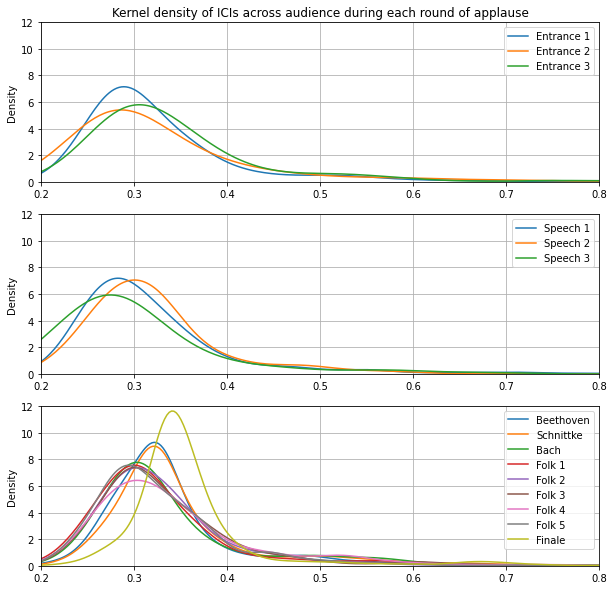

,Ratio clapping,Median number of Claps,STD number of Claps,Median L ICI P Median,Median L ICI P Spread,STD L ICI P Median,STD L ICI P Spread,Starting L ICI P Median,Starting L ICI P STD,Spread ICI Spread,...,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,Start spread,End spread,Duration Median
0,0.987654,38.0,9.998536,0.3,0.06,0.040256,0.112249,0.3,0.074806,0.051531,...,0.219397,0.05,0.2138,0.3,0.078789,0.035,0.077724,1.68,2.14,13.74
1,0.948718,17.0,4.088909,0.3,0.08,0.030367,0.044858,0.3,0.078707,0.032568,...,0.069449,0.04,0.061169,0.3,0.14649,0.04,0.164836,0.62,1.44,5.68
2,0.95122,21.0,6.138213,0.305,0.06,0.029481,0.047548,0.3,0.062988,0.044221,...,0.124594,0.04,0.155167,0.32,0.176074,0.04,0.206245,1.06,1.52,7.2
3,1.0,100.0,22.564893,0.32,0.04,0.049979,0.077396,0.3,0.069318,0.046049,...,0.08004,0.04,0.182424,0.3,0.0645,0.02,0.04739,1.2,6.18,37.26
4,0.653846,20.0,8.794294,0.3,0.075,0.091262,0.171728,0.3,0.090334,0.089706,...,0.229723,0.08,0.370079,0.3,0.116667,0.08,0.234468,6.36,5.64,10.62
5,1.0,133.5,34.858215,0.32,0.02875,0.06611,0.095088,0.305,0.076648,0.061993,...,0.122489,0.035,0.085034,0.32,0.229948,0.03,0.239592,2.02,2.64,55.76
6,1.0,32.0,10.118373,0.32,0.07,0.040156,0.109182,0.32,0.121447,0.07881,...,0.363396,0.08,0.409498,0.32,0.284297,0.06,0.25393,8.5,6.8,14.86
7,1.0,51.5,12.960839,0.31,0.03,0.043819,0.10773,0.31,0.13475,0.061474,...,0.157319,0.0425,0.151131,0.3,0.101886,0.04,0.178059,1.48,2.42,18.54
8,0.986842,39.0,10.275046,0.3,0.065,0.026795,0.055897,0.3,0.064707,0.043533,...,0.062173,0.03,0.044461,0.3,0.090329,0.04,0.049865,1.2,2.48,13.96
9,0.972973,47.0,11.752926,0.32,0.065,0.043411,0.063903,0.3,0.055674,0.040243,...,0.06101,0.04,0.071804,0.31,0.063491,0.035,0.042539,1.2,2.3,16.88


In [99]:
#claps_folder = './Data/new_indexp/clapping_peaks/'
stats_tags = ['Ratio clapping', 'Median number of Claps',
       'STD number of Claps', 'Median L ICI P Median', 'Median L ICI P Spread',
       'STD L ICI P Median', 'STD L ICI P Spread', 'Starting L ICI P Median',
       'Starting L ICI P STD', 'Spread ICI Spread',
       '5s ICI Median P Median', '5s ICI Median P STD',
       '5s ICI Quart P Median', '5s ICI Quart P STD',
       '5-10s ICI Median P Median', '5-10s ICI Median P STD',
       '5-10s ICI Quart P Median', '5-10s ICI Quart P STD',
       'Start spread', 'End spread','Duration Median']
Clapping_stats = pd.DataFrame(index = Applause_ints.index, columns = stats_tags)
t_interval = 1.5

f, (axes) = plt.subplots(3,1,figsize=[10,10])
apptypes = {'Entrance':0, 'Speech':1, 'Music':2}

# medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)

for app_int in Applause_ints.index:
    motions = pd.read_csv(claps_folder + Applause_ints.loc[app_int,'files'][:-9]+'motion.csv',index_col=0)
    movN = (motions.sum()>0).sum()
    peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[app_int,'files'],index_col=0)
    df_claps = peaks.fillna(0)
    df_OnlyClaps = df_claps.astype(bool).astype(int)
    total_claps = df_OnlyClaps.sum()
    # first and last claps as detected
    a = df_OnlyClaps.ne(0).idxmax()
    first_claps = a-a.median()
    b = df_OnlyClaps.iloc[::-1].ne(0).idxmax()
    last_claps = b-b.median()
    clapping_time = b - a
    
    sampletimes = np.arange(0,df_OnlyClaps.index[-1],0.5)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    #         clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
            if ici.notna().sum()>1:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0,:] = these_claps                                                                      

    print(Clap_Feats.max().max())
    # add condtion to cut  ICI feat values larger than a second? 
    Clap_Feats.loc()
    
    
    sub_claps = df_OnlyClaps.loc[0:5,:] # Excerpt of claps # offset of 5 s remember
#         clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    these_claps_med = these_claps.copy()
    these_claps_quart = these_claps.copy()
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps_med[partn]=np.nanmedian(ici)
            these_claps_quart[partn]=np.nanquantile(ici,[0.75])-np.nanquantile(ici,[0.25])
            
    sub_claps = df_OnlyClaps.loc[5:10,:] # Excerpt of claps
#         clap_stats = []
    cols = sub_claps.columns
    these_oth_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    these_oth_claps_med = these_oth_claps.copy()
    these_oth_claps_quart = these_oth_claps.copy()
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_oth_claps_med[partn]=np.nanmedian(ici)
            these_oth_claps_quart[partn]=np.nanquantile(ici,[0.75])-np.nanquantile(ici,[0.25])

    Clap_Feats=Clap_Feats.astype(float)
    quarts = Clap_Feats.astype(float).quantile([0.75]).values-Clap_Feats.astype(float).quantile([0.25]).values # quartile by time, not by clap
    Clapping_stats.loc[app_int,:] = [len(total_claps[total_claps>0])/movN,
                                     total_claps[total_claps>0].median(),
                                     total_claps[total_claps>0].std(),
                                     Clap_Feats.median().median(),
                                     np.nanquantile(Clap_Feats.median(),0.75)-np.nanquantile(Clap_Feats.median(),0.25), #Clap_Feats.median().std(), #
                                     Clap_Feats.std().median(),
                                     np.nanquantile(Clap_Feats.std(),0.75)-np.nanquantile(Clap_Feats.std(),0.25), #Clap_Feats.std().std(), #
                                     Clap_Feats.loc[:8.0,:].median().median(),
                                     Clap_Feats.loc[:8.0,:].median().std(),
                                     np.nanmean(quarts),
                                     these_claps_med.median(),
                                     these_claps_med.std(),
                                     these_claps_quart.median(),
                                     these_claps_quart.std(),
                                     these_oth_claps_med.median(),
                                     these_oth_claps_med.std(),
                                     these_oth_claps_quart.median(),
                                     these_oth_claps_quart.std(),
                                     np.nanquantile(first_claps,0.75)-np.nanquantile(first_claps,0.25),
                                     np.nanquantile(last_claps,0.75)-np.nanquantile(last_claps,0.25),
                                     np.nanquantile(clapping_time,0.5)]
    print(len(total_claps[total_claps>0]))
    B = Clap_Feats.melt().loc[:,'value']
#     B.loc[B.notnull()].hist(bins = 20)

    ax = axes[apptypes[Applause_ints.loc[app_int,'Type']]]
    B.loc[B.notnull()].plot.kde(label=Applause_ints.loc[app_int,'event_tag'],ax=ax)
#     plt.title(Applause_ints.loc[app_int,'files'][11:-9])
for j in range(3):
    ax = axes[j]
    ax.legend()
    ax.set_xlim([0.2,0.8])
    ax.set_ylim([0,12])
    ax.grid()
axes[0 ].set_title('Kernel density of ICIs across audience during each round of applause')
plt.savefig('./plots/dist_ICIs.png',bbox_inches = 'tight',dpi = 300)
plt.show()
Clapping_stats     

In [ ]:
Clapping_stats.columns

In [46]:
#['Ratio clapping', 'Median number of Claps',
#        'STD number of Claps', 'Median L ICI P Median', 'Median L ICI P Spread',
#        'STD L ICI P Median', 'STD L ICI P Spread', 'Starting L ICI P Median',
#        'Starting L ICI P STD', 'Spread ICI Spread',
#        '5s ICI Median P Median', '5s ICI Median P STD',
#        '5s ICI Quart P Median', '5s ICI Quart P STD',
#        '5-10s ICI Median P Median', '5-10s ICI Median P STD',
#        '5-10s ICI Quart P Median', '5-10s ICI Quart P STD',
#        'Start spread', 'End spread']

Clapping_stats.loc[:,['Ratio clapping','Duration Median','Median L ICI P Median','Starting L ICI P Median','Starting L ICI P STD','STD L ICI P Median', 'STD L ICI P Spread',
                     'Spread ICI Spread','Start spread', 'End spread']]

,Ratio clapping,Duration Median,Median L ICI P Median,Starting L ICI P Median,Starting L ICI P STD,STD L ICI P Median,STD L ICI P Spread,Spread ICI Spread,Start spread,End spread
0,0.987654,13.74,0.3,0.3,0.074806,0.040256,0.112249,0.051531,1.68,2.14
1,0.948718,5.68,0.3,0.3,0.078707,0.030367,0.044858,0.032568,0.62,1.44
2,0.95122,7.2,0.305,0.3,0.062988,0.029481,0.047548,0.044221,1.06,1.52
3,1.0,37.26,0.32,0.3,0.069318,0.049979,0.077396,0.046049,1.2,6.18
4,0.653846,10.62,0.3,0.3,0.090334,0.091262,0.171728,0.089706,6.36,5.64
5,1.0,55.76,0.32,0.305,0.076648,0.06611,0.095088,0.061993,2.02,2.64
6,1.0,14.86,0.32,0.32,0.121447,0.040156,0.109182,0.07881,8.5,6.8
7,1.0,18.54,0.31,0.31,0.13475,0.043819,0.10773,0.061474,1.48,2.42
8,0.986842,13.96,0.3,0.3,0.064707,0.026795,0.055897,0.043533,1.2,2.48
9,0.972973,16.88,0.32,0.3,0.055674,0.043411,0.063903,0.040243,1.2,2.3


Textures of applause. It looks like the average rate at which people clap across conditions is fairly stable, particularly to start. It is not dependent on the tempo of the music.

However differences between conditions are noticeable in:

    - Clapping duration (Duration Median)
    - ratio of participants clapping (Ratio clapping)
    - Readiness of clapping start (Start spread) 
    - Variation in initial clapping rate across participants (Starting L ICI P STD)
    - Variation in clapping stability across participants (STD L ICI P Spread)


# Clapping statistics per applause round by type
However we only have a few instances per type so the stats look very uninfomrative. 

Skip down to stats on individual clapping sequences statistics per type.
boo

In [47]:
Applause_ints=pd.read_csv('./data/Clapping_rounds_4.csv',index_col=0)

Applause_ints = pd.concat([Applause_ints,Clapping_stats.astype(float)],axis=1)
Applause_ints.to_csv('./data/Clapping_rounds_stats_ReCut3.csv')
Applause_ints.columns

Index(['start_time', 'end_time', 'duration', 'start_datetime', 'Type',
       'Type_M', 'Texture', 'event_tag', 'Applause_N', 'cue_start_time',
       'cue_start_type', 'cue_time2start', 'cue_end_time', 'cue_end_type',
       'cue_time2end', 'stage_next_time', 'stage_next_type',
       'stage_next_time2', 'files', 'links', 'Links_time(s)', 'Vid_times',
       'Links_ctime(s)', 'Ratio clapping', 'Median number of Claps',
       'STD number of Claps', 'Median L ICI P Median', 'Median L ICI P Spread',
       'STD L ICI P Median', 'STD L ICI P Spread', 'Starting L ICI P Median',
       'Starting L ICI P STD', 'Spread ICI Spread', '5s ICI Median P Median',
       '5s ICI Median P STD', '5s ICI Quart P Median', '5s ICI Quart P STD',
       '5-10s ICI Median P Median', '5-10s ICI Median P STD',
       '5-10s ICI Quart P Median', '5-10s ICI Quart P STD', 'Start spread',
       'End spread', 'Duration Median'],
      dtype='object')

In [53]:
feilds = ['start_time','event_tag','Texture','duration',
          'Starting L ICI P Median','Ratio clapping','Duration Median',
          'Start spread','Starting L ICI P STD',
          'STD L ICI P Median','STD L ICI P Spread',]
K = Applause_ints.loc[:,feilds].copy()
K.set_index('start_time',drop=True,inplace=True)
# print(K.to_latex())
K.round(2)

,event_tag,Texture,duration,Starting L ICI P Median,Ratio clapping,Duration Median,Start spread,Starting L ICI P STD,STD L ICI P Median,STD L ICI P Spread
start_time,,,,,,,,,,
-691.20,Entrance 1,Independent,17.10,0.30,0.99,13.74,1.68,0.07,0.04,0.11
-555.90,Speech 1,Independent,7.30,0.30,0.95,5.68,0.62,0.08,0.03,0.04
30.60,Speech 2,Independent,9.50,0.30,0.95,7.20,1.06,0.06,0.03,0.05
1610.60,Beethoven,Mixed,41.50,0.30,1.00,37.26,1.20,0.07,0.05,0.08
2004.80,Entrance 2,Independent,11.30,0.30,0.65,10.62,6.36,0.09,0.09,0.17
3282.60,Schnittke,Mixed,60.10,0.31,1.00,55.76,2.02,0.08,0.07,0.10
5001.92,Entrance 3,Independent,17.58,0.32,1.00,14.86,8.50,0.12,0.04,0.11
6020.10,Bach,Independent,22.00,0.31,1.00,18.54,1.48,0.13,0.04,0.11
6759.10,Folk 1,Independent,17.10,0.30,0.99,13.96,1.20,0.06,0.03,0.06


In [54]:
feilds = ['duration','Starting L ICI P Median','Ratio clapping','Duration Median',
          'Start spread','Starting L ICI P STD',
          'STD L ICI P Median','STD L ICI P Spread',]
Applause_ints.loc[:,feilds].corr()

,duration,Starting L ICI P Median,Ratio clapping,Duration Median,Start spread,Starting L ICI P STD,STD L ICI P Median,STD L ICI P Spread
duration,1.000000,0.442808,0.333152,0.999393,-0.228396,-0.310697,0.532830,0.081747
Starting L ICI P Median,0.442808,1.000000,0.556649,0.438628,-0.045665,-0.108533,0.112379,0.093976
Ratio clapping,0.333152,0.556649,1.000000,0.308761,-0.598768,-0.468775,-0.315759,-0.258579
Duration Median,0.999393,0.438628,0.308761,1.000000,-0.217219,-0.307327,0.541738,0.078632
Start spread,-0.228396,-0.045665,-0.598768,-0.217219,1.000000,0.674038,0.295990,0.512493
Starting L ICI P STD,-0.310697,-0.108533,-0.468775,-0.307327,0.674038,1.000000,-0.010942,0.285288
STD L ICI P Median,0.532830,0.112379,-0.315759,0.541738,0.295990,-0.010942,1.000000,0.758515
STD L ICI P Spread,0.081747,0.093976,-0.258579,0.078632,0.512493,0.285288,0.758515,1.000000


Textures of applause. It looks like the average rate (or Median ICI) at which this audience clapped across conditions was fairly stable, particularly to start. However the rounds of applause varied in other features that audibly affected the texture of applause, even in independent conditions. 

the most obvious differences

    - Clapping duration (Duration Median)
    - Ratio of participants clapping (Ratio clapping)
    - Readiness of clapping start (Start spread) 
    - Variation in initial clapping rate across participants (Starting L ICI P STD)
    - Variation in clapping stability across participants (STD L ICI P Spread)
    
The audience shapes their applause behaviour

Q statistics to quantify the relative independenc of these features? is this data set enough to quanitify? what is worth talking about at the individual applauder level vs total texture? 



In [51]:
feilds = ['start_time','event_tag','Texture','Ratio clapping','Duration Median','Median L ICI P Median','STD L ICI P Median',
          'Starting L ICI P Median','Starting L ICI P STD','STD L ICI P Median', 'STD L ICI P Spread',
                     'Spread ICI Spread','Start spread', 'End spread']
K = Applause_ints.loc[:,feilds].copy()
K.set_index('start_time',drop=True,inplace=True)
# print(K.to_latex())
K.round(2)

,event_tag,Texture,Ratio clapping,Duration Median,Median L ICI P Median,STD L ICI P Median,Starting L ICI P Median,Starting L ICI P STD,STD L ICI P Median,STD L ICI P Spread,Spread ICI Spread,Start spread,End spread
start_time,,,,,,,,,,,,,
-691.20,Entrance 1,Independent,0.99,13.74,0.30,0.04,0.30,0.07,0.04,0.11,0.05,1.68,2.14
-555.90,Speech 1,Independent,0.95,5.68,0.30,0.03,0.30,0.08,0.03,0.04,0.03,0.62,1.44
30.60,Speech 2,Independent,0.95,7.20,0.31,0.03,0.30,0.06,0.03,0.05,0.04,1.06,1.52
1610.60,Beethoven,Mixed,1.00,37.26,0.32,0.05,0.30,0.07,0.05,0.08,0.05,1.20,6.18
2004.80,Entrance 2,Independent,0.65,10.62,0.30,0.09,0.30,0.09,0.09,0.17,0.09,6.36,5.64
3282.60,Schnittke,Mixed,1.00,55.76,0.32,0.07,0.31,0.08,0.07,0.10,0.06,2.02,2.64
5001.92,Entrance 3,Independent,1.00,14.86,0.32,0.04,0.32,0.12,0.04,0.11,0.08,8.50,6.80
6020.10,Bach,Independent,1.00,18.54,0.31,0.04,0.31,0.13,0.04,0.11,0.06,1.48,2.42
6759.10,Folk 1,Independent,0.99,13.96,0.30,0.03,0.30,0.06,0.03,0.06,0.04,1.20,2.48


In [27]:
feilds = ['start_time','event_tag','Texture','duration','Ratio clapping','Median L ICI P Median', 'Starting L ICI P Median','First clap P Quart', 'Last clap P Quart']
K = Applause_ints.loc[:,feilds].copy()
K.set_index('start_time',drop=True,inplace=True)
print(K.to_latex())
K

\begin{tabular}{lllrrrrrr}
\toprule
{} &  event\_tag &      Texture &  duration &  Ratio clapping &  Median L ICI P Median &  Starting L ICI P Median &  First clap P Quart &  Last clap P Quart \\
start\_time &            &              &           &                 &                        &                          &                     &                    \\
\midrule
-691.20    &    Entre 1 &  Independent &     17.10 &        0.987654 &                  0.300 &                    0.300 &                1.68 &               2.14 \\
-555.90    &   Speech 1 &  Independent &      7.30 &        0.948718 &                  0.300 &                    0.300 &                0.62 &               1.44 \\
 30.60     &   Speech 2 &  Independent &      9.50 &        0.951220 &                  0.305 &                    0.300 &                1.06 &               1.52 \\
 1610.60   &  Beethoven &        Mixed &     41.50 &        1.000000 &                  0.320 &                    0.300 &    

,event_tag,Texture,duration,Ratio clapping,Median L ICI P Median,Starting L ICI P Median,First clap P Quart,Last clap P Quart
start_time,,,,,,,,
-691.20,Entre 1,Independent,17.10,0.987654,0.300,0.300,1.68,2.14
-555.90,Speech 1,Independent,7.30,0.948718,0.300,0.300,0.62,1.44
30.60,Speech 2,Independent,9.50,0.951220,0.305,0.300,1.06,1.52
1610.60,Beethoven,Mixed,41.50,1.000000,0.320,0.300,1.20,6.18
2004.80,Entre 2,Independent,11.30,0.653846,0.300,0.300,6.36,5.64
3282.60,Schnittke,Mixed,60.10,1.000000,0.320,0.305,2.02,2.64
5001.92,Entre 3,Independent,17.58,1.000000,0.320,0.320,8.50,6.80
6020.10,Bach,Independent,22.00,1.000000,0.310,0.310,1.48,2.42
6759.10,Folk 1,Independent,17.10,0.986842,0.300,0.300,1.20,2.48


In [28]:
60/Applause_ints.loc[:,'5s ICI Median P Median']

0     200.000000
1     200.000000
2     200.000000
3     200.000000
4     196.721311
5     187.500000
6     179.104478
7     187.500000
8     200.000000
9     200.000000
10    200.000000
11    187.500000
12    200.000000
13    210.526316
14    200.000000
Name: 5s ICI Median P Median, dtype: float64

In [69]:
Applause_ints.loc[:,['duration','Type','cue_start_type','Ratio clapping',
    'Median number of Claps', 'STD number of Claps',
    'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
    'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
    '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',
    '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
    'First clap P Quart','Last clap P Quart']]

,duration,Type,cue_start_type,Ratio clapping,Median number of Claps,STD number of Claps,Median L ICI P Median,Median L ICI P STD,STD L ICI P Median,STD L ICI P STD,...,5s ICI Median P Median,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,First clap P Quart,Last clap P Quart
0,17.10,Entrance,Musicians enter hall,0.987654,38.0,9.998536,0.300,0.061293,0.040256,0.088222,...,0.300,0.219397,0.0500,0.213800,0.30,0.078789,0.035,0.077724,1.68,2.14
1,7.30,Speech,Last word V,0.948718,17.0,4.088909,0.300,0.078707,0.030367,0.055935,...,0.300,0.069449,0.0400,0.061169,0.30,0.146490,0.040,0.164836,0.62,1.44
2,9.50,Speech,Last word MC,0.951220,21.0,6.138213,0.305,0.062568,0.029481,0.083089,...,0.300,0.124594,0.0400,0.155167,0.32,0.176074,0.040,0.206245,1.06,1.52
3,41.50,Music,Release instruments,1.000000,100.0,22.564893,0.320,0.055585,0.049979,0.048362,...,0.300,0.080040,0.0400,0.182424,0.30,0.064500,0.020,0.047390,1.20,6.18
4,11.30,Entrance,Musicians enter hall,0.653846,20.0,8.794294,0.300,0.074561,0.091262,0.102433,...,0.305,0.229723,0.0800,0.370079,0.30,0.116667,0.080,0.234468,6.36,5.64
5,60.10,Music,Release instruments,1.000000,133.5,34.858215,0.320,0.062878,0.066110,0.064656,...,0.320,0.122489,0.0350,0.085034,0.32,0.229948,0.030,0.239592,2.02,2.64
6,17.58,Entrance,Musicians enter hall,1.000000,32.0,10.118373,0.320,0.083468,0.040156,0.092688,...,0.335,0.363396,0.0800,0.409498,0.32,0.284297,0.060,0.253930,8.50,6.80
7,22.00,Music,Release instruments,1.000000,51.5,12.960839,0.310,0.073866,0.043819,0.082051,...,0.320,0.157319,0.0425,0.151131,0.30,0.101886,0.040,0.178059,1.48,2.42
8,17.10,Music,Last note,0.986842,39.0,10.275046,0.300,0.079145,0.026795,0.070818,...,0.300,0.062173,0.0300,0.044461,0.30,0.090329,0.040,0.049865,1.20,2.48
9,19.20,Music,Last note,0.972973,47.0,11.752926,0.320,0.060346,0.043411,0.065961,...,0.300,0.061010,0.0400,0.071804,0.31,0.063491,0.035,0.042539,1.20,2.30


In [44]:
numbs = Applause_ints.loc[:,['duration','Ratio clapping',
    'Median number of Claps', 'STD number of Claps',
    'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
    'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
    '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',                                                                      '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
    '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
    'First clap P Quart','Last clap P Quart']]
numbs.median()

duration                       17.100000
Ratio clapping                  0.986842
Median number of Claps         38.000000
STD number of Claps            10.100890
Median L ICI P Median           0.310000
Median L ICI P STD              0.068728
STD L ICI P Median              0.040156
STD L ICI P STD                 0.064656
Starting L ICI P Median         0.300000
Starting L ICI P STD            0.074806
Starting L ICI Quart P Mean     0.046049
5s ICI Median P Median          0.300000
5s ICI Median P STD             0.124594
5s ICI Quart P Median           0.040000
5s ICI Quart P STD              0.144723
5-10s ICI Median P Median       0.315000
5-10s ICI Median P STD          0.085748
5-10s ICI Quart P Median        0.037500
5-10s ICI Quart P STD           0.077115
5-10s ICI Median P Median       0.315000
5-10s ICI Median P STD          0.085748
5-10s ICI Quart P Median        0.037500
5-10s ICI Quart P STD           0.077115
First clap P Quart              1.200000
Last clap P Quar

In [46]:
ctypes = Applause_ints['Type'].unique()
types_stats = pd.DataFrame(columns = ctypes)
for c in ctypes:
    types_stats.loc[:,c] = Applause_ints.loc[Applause_ints['Type']==c,['duration','Ratio clapping',
        'Median number of Claps', 'STD number of Claps',
        'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
        'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
        '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',
        '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
        'First clap P Quart','Last clap P Quart']].mean()

types_stats.loc['Counts',:] = [3, 3, 9]
types_stats.to_csv('./data/Clapping_types_stats.csv')
types_stats

,Entrance,Speech,Music
duration,15.326667,7.200000,34.900000
Ratio clapping,0.880500,0.843358,0.990969
Median number of Claps,30.000000,15.833333,82.333333
STD number of Claps,9.637068,4.559853,22.155723
Median L ICI P Median,0.306667,0.296667,0.317778
Median L ICI P STD,0.073107,0.094558,0.066370
STD L ICI P Median,0.057225,0.031077,0.043772
STD L ICI P STD,0.094448,0.065579,0.061234
Starting L ICI P Median,0.306667,0.295000,0.307222
Starting L ICI P STD,0.095529,0.094698,0.072827


In [47]:
print(types_stats.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   Entrance &     Speech &      Music \\
\midrule
duration                    &  15.326667 &   7.200000 &  34.900000 \\
Ratio clapping              &   0.880500 &   0.843358 &   0.990969 \\
Median number of Claps      &  30.000000 &  15.833333 &  82.333333 \\
STD number of Claps         &   9.637068 &   4.559853 &  22.155723 \\
Median L ICI P Median       &   0.306667 &   0.296667 &   0.317778 \\
Median L ICI P STD          &   0.073107 &   0.094558 &   0.066370 \\
STD L ICI P Median          &   0.057225 &   0.031077 &   0.043772 \\
STD L ICI P STD             &   0.094448 &   0.065579 &   0.061234 \\
Starting L ICI P Median     &   0.306667 &   0.295000 &   0.307222 \\
Starting L ICI P STD        &   0.095529 &   0.094698 &   0.072827 \\
Starting L ICI Quart P Mean &   0.073349 &   0.037698 &   0.048150 \\
5s ICI Median P Median      &   0.313333 &   0.295000 &   0.306667 \\
5s ICI Median P STD         &   0.270839 &   0.112238 &   0.109606 \\
5s IC

duration
   Source  ddof1    ddof2         F     p-unc       np2
0  Type_M      1  8.61666  4.487214  0.064558  0.170789
LeveneResult(statistic=1.2397661784687337, pvalue=0.28732248390991194)
Median number of Claps
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.435274  5.388172  0.047225  0.196985
LeveneResult(statistic=1.3363248941158263, pvalue=0.27018028976968467)
Ratio clapping
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.029713  1.642599  0.268744  0.207278
LeveneResult(statistic=2.803531801706052, pvalue=0.11989967725430369)


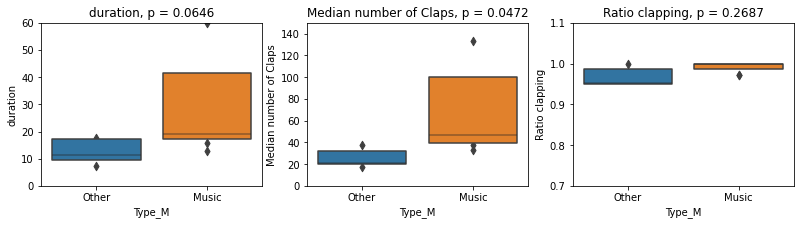

Median L ICI P Median
   Source  ddof1      ddof2         F     p-unc       np2
0  Type_M      1  10.212277  5.775109  0.036638  0.294773
LeveneResult(statistic=0.11904761904764924, pvalue=0.7360419681084175)
Median L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.716354  1.064786  0.329906  0.079513
LeveneResult(statistic=0.017191529664115187, pvalue=0.897855709762455)
STD L ICI P Median
   Source  ddof1    ddof2         F     p-unc       np2
0  Type_M      1  5.85471  0.039769  0.848678  0.004307
LeveneResult(statistic=0.06018291918488295, pvalue=0.8103523191131248)
STD L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  6.191381  6.991351  0.037209  0.420862
LeveneResult(statistic=0.20494125706920638, pvalue=0.6588373502309437)


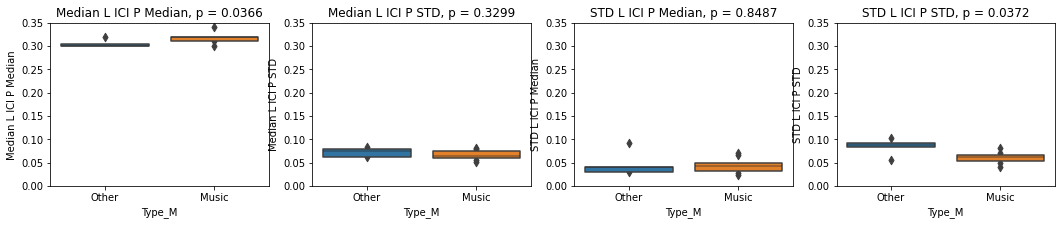

Starting L ICI P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  7.872814  0.437793  0.527077  0.036717
LeveneResult(statistic=0.5274725274725179, pvalue=0.481598068920561)
Starting L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  9.166241  0.988614  0.345603  0.071869
LeveneResult(statistic=0.005920003582821263, pvalue=0.9399380144346466)


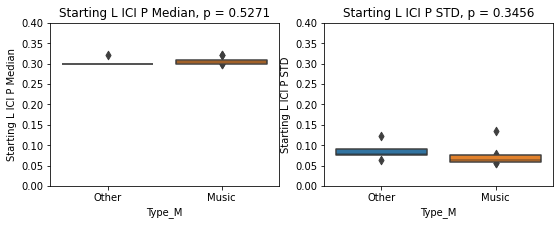

5s ICI Median P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  5.969555  0.030858  0.866364  0.003292
LeveneResult(statistic=0.03963666391411674, pvalue=0.8455261225122075)
5s ICI Median P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.682614  3.062064  0.144506  0.290626
LeveneResult(statistic=3.0449998145894255, pvalue=0.10651591155782228)
5s ICI Quart P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.166163  4.901669  0.088525  0.428038
LeveneResult(statistic=7.908468485966364, pvalue=0.01568527282608413)
5s ICI Quart P STD
   Source  ddof1     ddof2         F     p-unc      np2
0  Type_M      1  4.543707  3.702299  0.118114  0.33841
LeveneResult(statistic=5.6146116683478065, pvalue=0.03543255012741431)


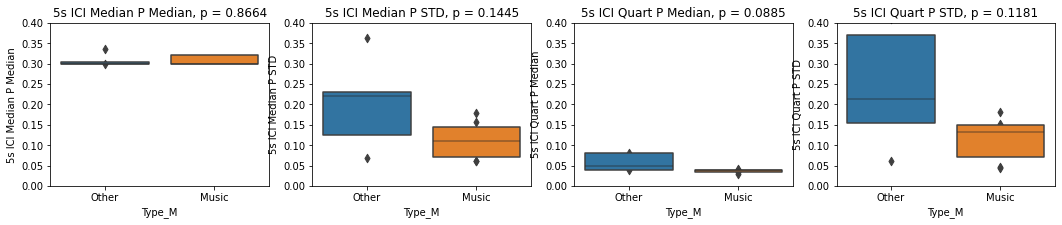

5-10s ICI Median P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  7.541747  0.516822  0.493869  0.044322
LeveneResult(statistic=0.0015416238437827333, pvalue=0.9693259593724125)
5-10s ICI Median P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  6.108531  2.899771  0.138605  0.233521
LeveneResult(statistic=0.9082967912965675, pvalue=0.3593703552800377)
5-10s ICI Quart P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.636276  4.076923  0.103927  0.355345
LeveneResult(statistic=1.7888198757764657, pvalue=0.20586821185737877)
5-10s ICI Quart P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.515261  6.468454  0.032893  0.347818
LeveneResult(statistic=0.0584010924808604, pvalue=0.8131214224778367)


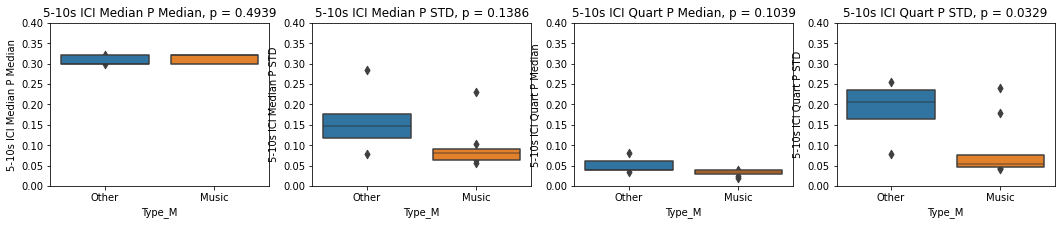

First clap P Quart
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.046085  2.337212  0.200248  0.270137
LeveneResult(statistic=6.2007003579237345, pvalue=0.02842582137620353)
Last clap P Quart
   Source  ddof1     ddof2         F    p-unc       np2
0  Type_M      1  6.555408  0.102961  0.75829  0.010134
LeveneResult(statistic=0.5893765611739975, pvalue=0.4575011433719919)


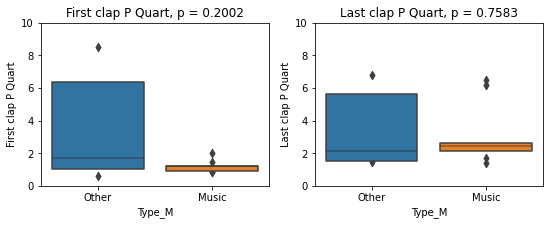

In [51]:
test_feats = [['duration', 'Median number of Claps','Ratio clapping'],
# ICI stats on variable length clapping intervals is hard to interpret
             ['Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD'],
# starting Local ICI (8s) gives a comparable view of the initial texture differences
             ['Starting L ICI P Median','Starting L ICI P STD'], # ,'Starting L ICI Quart P Mean' quartile too rough to evaluate differences on
# 5 s ICI stats tell the same story as the smoothed initial local ICI: 
    # not so different between types in clapping rate central tendency, but accross participants, the rates are significantly more consistent for music
              ['5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD'],
              ['5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD'],
    # time to first clap tends to be fast for music, but speachs vary a lot, so not clear distinction.
    # time to last clap tends to be longer too for music,
    # but this may be related to the longer clapping interval and some less clear clues for ending
              ['First clap P Quart','Last clap P Quart']]

v_range = {'duration':[0,60],'Median number of Claps':[0,150],'Ratio clapping':[0.7,1.1],
           'Median L ICI P Median':[0.0,0.35],'Median L ICI P STD':[0.0,0.35],'STD L ICI P Median':[0.0,0.35],'STD L ICI P STD':[0.0,0.35],
           'Starting L ICI P Median':[0.0,0.4],'Starting L ICI P STD':[0.0,0.4],'Starting L ICI Quart P Mean':[0.0,0.4],
           '5s ICI Median P Median':[0.0,0.4],'5s ICI Median P STD':[0.0,0.4],
           '5s Med ICI Median':[0.0,0.4], '5s Med ICI STD':[0.0,0.4],
           '5s ICI Quart P Median':[0.0,0.4], '5s ICI Quart P STD':[0.0,0.4],
           '5-10s ICI Median P Median':[0.0,0.4],'5-10s ICI Median P STD':[0.0,0.4],
           '5-10s ICI Quart P Median':[0.0,0.4], '5-10s ICI Quart P STD':[0.0,0.4],
           'First clap P Quart':[0.0,10], 'Last clap P Quart':[0.0,10]}

sub_ints = Applause_ints.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,14],:]

for vs in test_feats:
    f, a = plt.subplots(1,len(vs),figsize=(4.5*len(vs),3)) 
    for i in range(len(vs)):
        ax_i = a[i]
        v = vs[i]
        aov = pg.welch_anova(dv=v, between = 'Type_M', data = sub_ints)
        print(v)
        print(aov)

        sns.boxenplot(x = 'Type_M',y = v, data = sub_ints,ax = ax_i)
        ax_i.set_title(v + ', p = ' + "{:.4f}".format(aov['p-unc'].values[0]))
        ax_i.set_ylim(v_range[v])

        
#         group1 = sub_ints.loc[sub_ints['Type']=='Entrance',v].values
#         group2 = sub_ints.loc[sub_ints['Type']=='Speech',v].values
#         group2 = sub_ints.loc[sub_ints['Type']=='Music',v].values
        group1 = sub_ints.loc[sub_ints['Type_M']=='Other',v].values
        group2 = sub_ints.loc[sub_ints['Type_M']=='Music',v].values
        s = sp.stats.levene(group1, group2, center='median') #https://www.statology.org/brown-forsythe-test-in-python/
        print(s)
    plt.savefig('plots/clapping_m_types_stats_'+vs[0]+'_set.png',bbox_inches = 'tight',dpi = 300)
    plt.show()

In [69]:
s.pvalue

0.8131214224778367

duration
   Source  ddof1    ddof2         F     p-unc       np2
0  Type_M      1  8.61666  4.487214  0.064558  0.170789
LeveneResult(statistic=1.2397661784687337, pvalue=0.28732248390991194)
Ratio clapping
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.029713  1.642599  0.268744  0.207278
LeveneResult(statistic=2.803531801706052, pvalue=0.11989967725430369)
First clap P Quart
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.046085  2.337212  0.200248  0.270137
LeveneResult(statistic=6.2007003579237345, pvalue=0.02842582137620353)


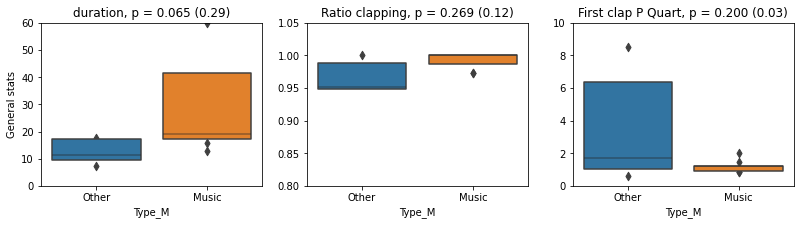

Median L ICI P Median
   Source  ddof1      ddof2         F     p-unc       np2
0  Type_M      1  10.212277  5.775109  0.036638  0.294773
LeveneResult(statistic=0.11904761904764924, pvalue=0.7360419681084175)
5s ICI Median P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  5.969555  0.030858  0.866364  0.003292
LeveneResult(statistic=0.03963666391411674, pvalue=0.8455261225122075)
5-10s ICI Median P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  7.541747  0.516822  0.493869  0.044322
LeveneResult(statistic=0.0015416238437827333, pvalue=0.9693259593724125)


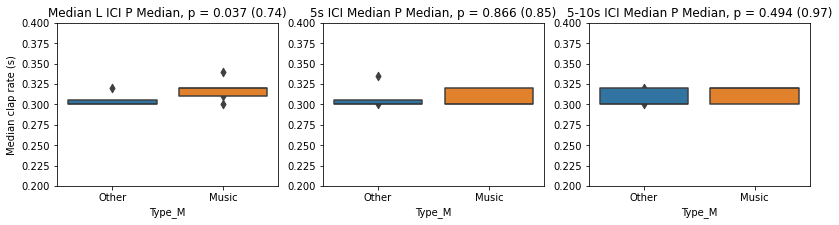

Median L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.716354  1.064786  0.329906  0.079513
LeveneResult(statistic=0.017191529664115187, pvalue=0.897855709762455)
5s ICI Median P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.682614  3.062064  0.144506  0.290626
LeveneResult(statistic=3.0449998145894255, pvalue=0.10651591155782228)
5-10s ICI Median P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  6.108531  2.899771  0.138605  0.233521
LeveneResult(statistic=0.9082967912965675, pvalue=0.3593703552800377)


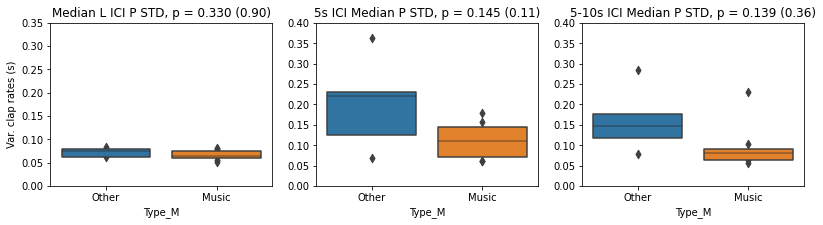

STD L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  6.191381  6.991351  0.037209  0.420862
LeveneResult(statistic=0.20494125706920638, pvalue=0.6588373502309437)
5s ICI Quart P STD
   Source  ddof1     ddof2         F     p-unc      np2
0  Type_M      1  4.543707  3.702299  0.118114  0.33841
LeveneResult(statistic=5.6146116683478065, pvalue=0.03543255012741431)
5-10s ICI Quart P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.515261  6.468454  0.032893  0.347818
LeveneResult(statistic=0.0584010924808604, pvalue=0.8131214224778367)


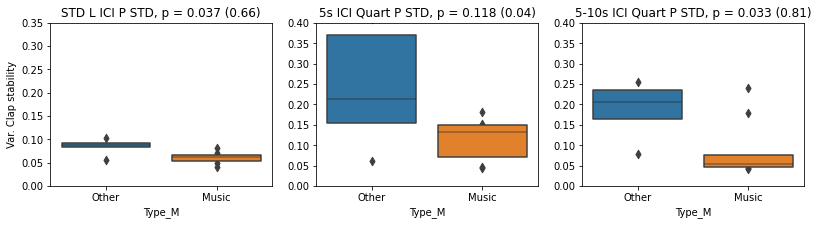

In [73]:
test_feats = [['duration','Ratio clapping','First clap P Quart'],
             ['Median L ICI P Median','5s ICI Median P Median','5-10s ICI Median P Median'],
             ['Median L ICI P STD','5s ICI Median P STD','5-10s ICI Median P STD'], 
              ['STD L ICI P STD','5s ICI Quart P STD','5-10s ICI Quart P STD']]

test_feat_labels = ['General stats','Median clap rate (s)','Var. clap rates (s)','Var. Clap stability']
v_range = {'duration':[0,60],'Median number of Claps':[0,150],'Ratio clapping':[0.8,1.05],
           'Median L ICI P Median':[0.2,0.4],'Median L ICI P STD':[0.0,0.35],'STD L ICI P Median':[0.0,0.35],'STD L ICI P STD':[0.0,0.35],
           'Starting L ICI P Median':[0.0,0.4],'Starting L ICI P STD':[0.0,0.4],'Starting L ICI Quart P Mean':[0.0,0.4],
           '5s ICI Median P Median':[0.2,0.4],'5s ICI Median P STD':[0.0,0.4],
           '5s Med ICI Median':[0.0,0.4], '5s Med ICI STD':[0.0,0.4],
           '5s ICI Quart P Median':[0.0,0.4], '5s ICI Quart P STD':[0.0,0.4],
           '5-10s ICI Median P Median':[0.2,0.4],'5-10s ICI Median P STD':[0.0,0.4],
           '5-10s ICI Quart P Median':[0.0,0.4], '5-10s ICI Quart P STD':[0.0,0.4],
           'First clap P Quart':[0.0,10], 'Last clap P Quart':[0.0,10]}

sub_ints = Applause_ints.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,14],:]

for j in range(len(test_feats)):
    vs = test_feats[j]
    f, a = plt.subplots(1,len(vs),figsize=(4.5*len(vs),3)) 
    for i in range(len(vs)):
        ax_i = a[i]
        v = vs[i]
        aov = pg.welch_anova(dv=v, between = 'Type_M', data = sub_ints)
        print(v)
        print(aov)

        sns.boxenplot(x = 'Type_M',y = v, data = sub_ints,ax = ax_i)
        ax_i.set_ylim(v_range[v])
        ax_i.set_ylabel('')
        if i == 0:
            ax_i.set_ylabel(test_feat_labels[j])

#         group1 = sub_ints.loc[sub_ints['Type']=='Entrance',v].values
#         group2 = sub_ints.loc[sub_ints['Type']=='Speech',v].values
#         group3 = sub_ints.loc[sub_ints['Type']=='Music',v].values
        group2 = sub_ints.loc[sub_ints['Type_M']=='Other',v].values
        group1 = sub_ints.loc[sub_ints['Type_M']=='Music',v].values
        s = sp.stats.levene(group1, group2, center='median') #https://www.statology.org/brown-forsythe-test-in-python/
        print(s)
        ax_i.set_title(v + ', p = ' + "{:.3f}".format(aov['p-unc'].values[0]) + ' (' + "{:.2f}".format(s.pvalue)+')')

    plt.savefig('plots/clapping_m_types_stats_'+vs[0]+'_set.png',bbox_inches = 'tight',dpi = 300)
    plt.show()

When evaluating these summary applause statistics per interval with a one-way anova that allows for unequal variance (Welch), the things being applauded seem to be a significant factor for:  * p<.05, ** p<.01, *** p<.001. Test for difference in variance (Levene...)
Notes: These are very small samples, so only big effects can be caught. 

    - Median number of Claps*, which is proportional to applause duration
    - The median clapping rate*, Music conditions tends to be a bit slower, which may be an artifact of the duration of the applause intervals. Indeed, there was not measurable systematic difference in initial clapping rates for music and non music rounds (5s ICI Median P Median)
    - Variation in variability: STD L ICI STD* and 5-10s ICI Quart P STD* significantly higher across other than Music condition. There tends to be more variance across participants in their variance of local ICI for non-music applause intervals. Meaning participants are less stable in the clapping rates initially, even if they tending to similar rates. Some of this uncertainty may be due to slow starts to entrance applause rounds. The variability in initial variability between is non-music instances was also signiciantly larger than across the music pieces (Brown-Forsyth test of unequal variance for 5s ICI Quart P Median*, 5s ICI Quart P STD*). The variation in starting time is also much greater across non-music rounds of applause (Brown-Forsyth test of unequal variance on First clap P Quart*).
    
These results suggest that there is a difference in the stability of participants claps that depends on what they are clapping for, and that this difference is more pronounced at the begining of an interval of applause. 

A stronger test of this behaviour would be to allow participants contributions to be recognised and balanced in a repeated measures design.

In [74]:
Applause_ints

,start_time,end_time,duration,start_datetime,Type,Type_M,Texture,event_tag,Applause_N,cue_start_time,...,5s ICI Median P Median,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,First clap P Quart,Last clap P Quart
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entrance,Other,Independent,Entre 1,1,-692.20,...,0.300,0.219397,0.0500,0.213800,0.30,0.078789,0.035,0.077724,1.68,2.14
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech,Other,Independent,Speech 1,2,-556.10,...,0.300,0.069449,0.0400,0.061169,0.30,0.146490,0.040,0.164836,0.62,1.44
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech,Other,Independent,Speech 2,3,31.00,...,0.300,0.124594,0.0400,0.155167,0.32,0.176074,0.040,0.206245,1.06,1.52
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Music,Music,Mixed,Beethoven,4,1609.60,...,0.300,0.080040,0.0400,0.182424,0.30,0.064500,0.020,0.047390,1.20,6.18
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entrance,Other,Independent,Entre 2,5,2004.80,...,0.305,0.229723,0.0800,0.370079,0.30,0.116667,0.080,0.234468,6.36,5.64
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Music,Music,Mixed,Schnittke,6,3278.90,...,0.320,0.122489,0.0350,0.085034,0.32,0.229948,0.030,0.239592,2.02,2.64
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entrance,Other,Independent,Entre 3,7,5001.92,...,0.335,0.363396,0.0800,0.409498,0.32,0.284297,0.060,0.253930,8.50,6.80
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Music,Music,Independent,Bach,8,6017.20,...,0.320,0.157319,0.0425,0.151131,0.30,0.101886,0.040,0.178059,1.48,2.42
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Music,Music,Independent,Folk 1,9,6756.90,...,0.300,0.062173,0.0300,0.044461,0.30,0.090329,0.040,0.049865,1.20,2.48
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Music,Music,Independent,Folk 2,10,6931.90,...,0.300,0.061010,0.0400,0.071804,0.31,0.063491,0.035,0.042539,1.20,2.30


# Clapping sequence stats per prompt type
This comparison has numbers we can interpret using ANOVA with repeated measures to encorporate participant clapping tendencies against differences per prompt type. 


In [42]:
# pull audience questionnair responses
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1',index_col = 0)
subQs=['age','gender','musician_status','fan','moved_Beethoven','moved_Schnittke','KM_Beethoven',
       'KM_Schnittke','AWE_Beethoven', 'AWE_Schnittke']
Quest_df = Quest_df.loc[:,subQs]


In [43]:
partDets

,PartN3,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Exclusion,Temp_Codes,Paper_QCodes,App_QCode,Usher_QCode,...,Lattitude,Longitude_Truncated,Lattitude_Truncated,MusicLab_DevID,Motion_DevID,Aligned_DevID,Questionnaire_NAs,Offset_1,Offset_2,Watch_Alone
Participant_Code,,,,,,,,,,,,,,,,,,,,,
ADQ001,1,1,A,D,Q,No,D098,DSQd098,DSQd098,D098,...,NaN,NaN,NaN,0ab9bf2b-a0c7-f823-0fde-6295eedb207e,0ab9bf2b-a0c7-f823-0fde-6295eedb207e,0ab9bf2b-a0c7-f823-0fde-6295eedb207e,13.0,0.14,0.16,0.0
ADQ002,2,2,A,D,Q,No,D139,DSQd139,DSQd139,D139,...,NaN,NaN,NaN,2b36bb42-2be3-9075-0de9-1cc9d3480a55,2b36bb42-2be3-9075-0de9-1cc9d3480a55,2b36bb42-2be3-9075-0de9-1cc9d3480a55,13.0,NaN,-0.36,0.0
ADQ003,3,3,A,D,Q,No,D123,DSQd123,DSQd123,D123,...,NaN,NaN,NaN,3aa57dd8-4d97-a01d-61ff-3139f2f2609b,3aa57dd8-4d97-a01d-61ff-3139f2f2609b,3aa57dd8-4d97-a01d-61ff-3139f2f2609b,13.0,0.88,1.02,0.0
ADQ004,4,4,A,D,Q,No,D055,DSQd055,DSQd055,D055,...,NaN,NaN,NaN,49472968-4242-c1b7-98c2-3a5c60c33d39,49472968-4242-c1b7-98c2-3a5c60c33d39,49472968-4242-c1b7-98c2-3a5c60c33d39,13.0,0.44,0.62,1.0
ADQ005,5,5,A,D,Q,No,D091,DSQd091,DSQd091,D091,...,NaN,NaN,NaN,6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25,6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25,6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25,13.0,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AEQ087,87,87,A,E,Q,No,E029,DSQe029,NaN,E029,...,NaN,NaN,NaN,2119fe13-3a70-e293-0818-60c9574580f1,2119fe13-3a70-e293-0818-60c9574580f1,2119fe13-3a70-e293-0818-60c9574580f1,18.0,0.12,0.28,0.0
AEQ088,88,88,A,E,Q,No,E019,DSQe019,DSQe019,E019,...,NaN,NaN,NaN,2db31f15-6d47-da79-ab6a-02b55c6d065b,2db31f15-6d47-da79-ab6a-02b55c6d065b,2db31f15-6d47-da79-ab6a-02b55c6d065b,19.0,0.10,0.06,0.0
AEQ089,89,89,A,E,Q,No,E026,DSQe026,DSQe026,E026,...,NaN,NaN,NaN,891551b7-70e2-2032-3ea0-3a3335b15901,891551b7-70e2-2032-3ea0-3a3335b15901,891551b7-70e2-2032-3ea0-3a3335b15901,20.0,0.28,0.38,0.0


In [44]:
# assessing participant stats per work, not just summary
# note: pinguine can't deal with nan's, but can work around missing values
#claps_folder = './Data/new_indexp/clapping_peaks/'
Clapping_Indiv_stats = pd.DataFrame(index = Applause_ints.index, columns = ['Ratio clapping','Median number of Claps','STD number of Claps','Median ICI Median','Median ICI STD','STD ICI Median','STD ICI STD','Starting ICI Median','Starting ICI STD','Starting ICI Quart','5s Med ICI Median','5s Med ICI STD','5s quart ICI Median','5s quart ICI STD'])
t_interval = 1.5 # interval for ICI local assessment(half)
init_t = 8 # The time from zero (first clap) over which clapping stats are assessed for initiatory clap patterns
all_clapperings = pd.DataFrame()

for app_int in Applause_ints.index: # for each instance of clapping 
    app_type = Applause_ints.loc[app_int,'Type']
    app_Mtype = Applause_ints.loc[app_int,'Type_M']
    
    #call up the claps, convert to boolean sparse matrix with steady sample rate
    peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[app_int,'files'],index_col=0)
    df_claps = peaks.fillna(0)
    df_OnlyClaps = df_claps.astype(bool).astype(int)
    total_claps = df_OnlyClaps.sum()
    df_OnlyClaps = df_OnlyClaps.loc[:,total_claps>0]
        # first and last claps as detected, note this is sensitive to quality of detection
    a = df_OnlyClaps.ne(0).idxmax()
    first_claps = a-a.min()
    a = df_OnlyClaps.iloc[::-1].ne(0).idxmax()
    last_claps = a-a.max()
    
    clapperings = pd.DataFrame(index = df_OnlyClaps.columns)
    clapperings['Type'] = app_type
    clapperings['Type_M'] = app_Mtype
    clapperings['Instance'] = Applause_ints.loc[app_int,'Applause_N'] 
    clapperings['Time'] = Applause_ints.loc[app_int,'start_time'] 

    clapperings['Event_tag'] = Applause_ints.loc[app_int,'event_tag']
    clapperings['Participant'] = clapperings.index
    clapperings['Age'] = Quest_df.loc[clapperings.index,'age']
    clapperings['Gender'] = Quest_df.loc[clapperings.index,'gender']
    clapperings['Musicianship'] = Quest_df.loc[clapperings.index,'musician_status']
    clapperings['Fan_status'] = Quest_df.loc[clapperings.index,'fan']
    clapperings['Seat_Zone'] = partDets.loc[clapperings.index,'Seat_Zone']

    if app_int == 3:
        clapperings['KM'] = Quest_df.loc[clapperings['Participant'],'KM_Beethoven']
        clapperings['AWE'] = Quest_df.loc[clapperings['Participant'],'AWE_Beethoven']
        clapperings['Moved'] = Quest_df.loc[clapperings['Participant'],'moved_Beethoven']
    elif app_int == 5:
        clapperings['KM'] = Quest_df.loc[clapperings['Participant'],'KM_Schnittke']
        clapperings['AWE'] = Quest_df.loc[clapperings['Participant'],'AWE_Schnittke']
        clapperings['Moved'] = Quest_df.loc[clapperings['Participant'],'moved_Schnittke']
    else:
        clapperings['KM'] = np.nan
        clapperings['AWE'] = np.nan
        clapperings['Moved'] = np.nan
    
    clapperings['Clap Count'] = total_claps[total_claps>0]
    

    # assess local ICIs 
    sampletimes = np.arange(0,df_OnlyClaps.index[-1]-5,0.5)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
#         clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
            if ici.notna().sum()>1:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0,:] = these_claps
     
    clapperings['ICI Median'] = Clap_Feats.median()
    clapperings['Average Rate'] = 60/Clap_Feats.mean() # in BPM
    clapperings['ICI STD'] = Clap_Feats.std()
    clapperings['ICI quartiles'] = (Clap_Feats.astype(float).quantile([0.75]).values-Clap_Feats.astype(float).quantile([0.25]).values)[0] # quartile by time, not by clap
    clapperings['Relative first clap']=first_claps
    clapperings['Relative last clap']=last_claps
    
    # looking at first 
    sub_claps = df_OnlyClaps.loc[:init_t,:] # Excerpt of claps
#         clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    these_claps_med = these_claps.copy()
    these_claps_quart = these_claps.copy()
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps_med[partn]=np.nanmedian(ici)
            these_claps_quart[partn]=np.nanquantile(ici,[0.75])-np.nanquantile(ici,[0.25])
    clapperings['Initial 8s ICI Median'] = these_claps_med
    clapperings['Initial 8s ICI quartiles'] = these_claps_quart    

    all_clapperings = pd.concat([all_clapperings,clapperings],ignore_index=True)
    
#all_clapperings

In [45]:
all_clapperings['Musicianship'].unique()
ranks = {'Professional musician':5,
         'Semiprofessional musician':4,
         'Serious amateur musician':3,
         'Amateur musician':2,
         'Music-loving nonmusician':1, 
         'Nonmusician':0}
all_clapperings['Music_Exp'] = 0
for r in ranks.keys(): all_clapperings.loc[all_clapperings['Musicianship']==r,'Music_Exp'] = ranks[r]

In [46]:
print(len(all_clapperings))
all_clapperings.columns

1062


Index(['Type', 'Type_M', 'Instance', 'Time', 'Event_tag', 'Participant', 'Age',
       'Gender', 'Musicianship', 'Fan_status', 'Seat_Zone', 'KM', 'AWE',
       'Moved', 'Clap Count', 'ICI Median', 'Average Rate', 'ICI STD',
       'ICI quartiles', 'Relative first clap', 'Relative last clap',
       'Initial 8s ICI Median', 'Initial 8s ICI quartiles', 'Music_Exp'],
      dtype='object')

In [47]:
all_clapperings.iloc[:3,:]

,Type,Type_M,Instance,Time,Event_tag,Participant,Age,Gender,Musicianship,Fan_status,...,Clap Count,ICI Median,Average Rate,ICI STD,ICI quartiles,Relative first clap,Relative last clap,Initial 8s ICI Median,Initial 8s ICI quartiles,Music_Exp
0,Entrance,Other,1,-691.2,Entre 1,ADQ001,60.0,Woman,Music-loving nonmusician,7.0,...,42,0.24,240.770465,0.015524,0.0200,6.08,-0.92,0.24,0.045,1
1,Entrance,Other,1,-691.2,Entre 1,ADQ002,84.0,Man,Music-loving nonmusician,7.0,...,28,0.38,135.770235,0.253062,0.1375,0.46,-2.28,0.44,0.350,1
2,Entrance,Other,1,-691.2,Entre 1,ADQ003,46.0,Man,Music-loving nonmusician,7.0,...,60,0.26,232.300885,0.012715,0.0100,1.00,-0.32,0.26,0.020,1


In [117]:
#all_clapperings.to_csv('Clapping_traints_Part_all.csv')
all_clapperings=pd.read_csv('Clapping_traints_Part_all.csv',index_col = 0)

Clap Count
         Source         W     ddof1       ddof2            F          p-unc
Friedman   Type  0.975016  1.974359  152.025641  3005.026316  1.492472e-122
Average Rate
         Source         W     ddof1       ddof2          F     p-unc
Friedman   Type  0.130342  1.974359  152.025641  11.540541  0.000024


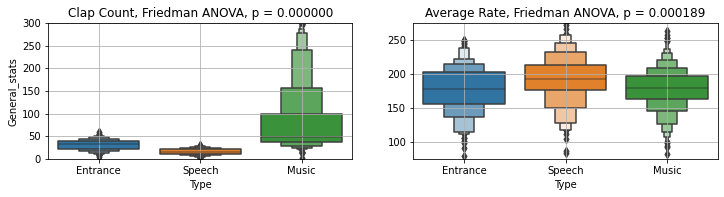

ICI Median
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.154011  1.974359  152.025641  14.01768  0.000003
Initial 8s ICI Median
         Source        W     ddof1       ddof2         F     p-unc
Friedman   Type  0.08019  1.974359  152.025641  6.712963  0.001685


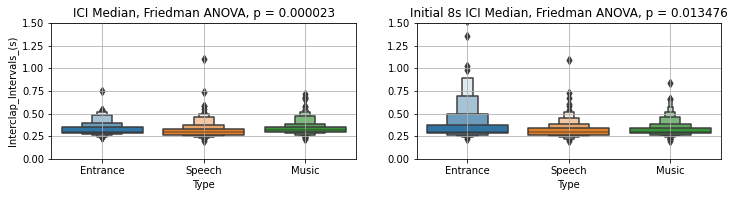

ICI quartiles
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.090894  1.974359  152.025641  7.698608  0.000691
Initial 8s ICI quartiles
         Source         W     ddof1       ddof2          F     p-unc
Friedman   Type  0.154629  1.974359  152.025641  14.084313  0.000003


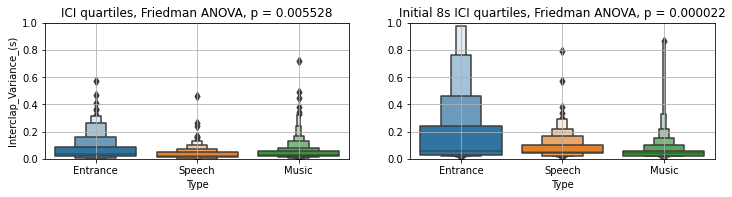

Relative first clap
         Source         W     ddof1       ddof2         F         p-unc
Friedman   Type  0.202334  1.974359  152.025641  19.53163  3.298721e-08
Relative last clap
         Source         W     ddof1       ddof2          F         p-unc
Friedman   Type  0.445266  1.974359  152.025641  61.805333  3.343026e-20


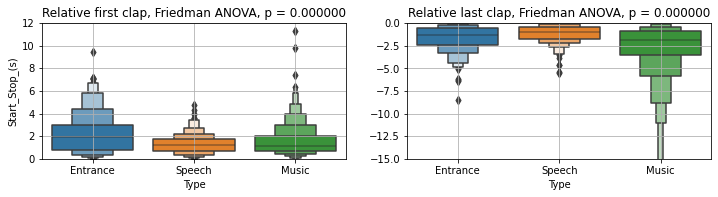

In [103]:
test_feats = [['Clap Count','Average Rate'],
             ['ICI Median','Initial 8s ICI Median'],
             ['ICI quartiles','Initial 8s ICI quartiles'], 
             ['Relative first clap','Relative last clap']]
test_feat_labels = ['General_stats','Interclap_Intervals_(s)','Interclap_Variance_(s)','Start_Stop_(s)']

v_range = {'Clap Count':[0,300], 'Average Rate':[75,275], 'ICI Median':[0.0,1.5], 'ICI STD':[0.0,1.5], 'ICI quartiles':[0.0,1.0],
       'Initial 8s ICI Median':[0.0,1.5], 'Initial 8s ICI quartiles':[0.0,1.0],'Relative first clap':[0.0,12],'Relative last clap':[-15.0,0]}


for j in range(len(test_feats)):
    vs = test_feats[j]
    f, a = plt.subplots(1,len(vs),figsize=(6*len(vs),2.5)) 
    for i in range(len(vs)):
        ax_i = a[i]
        v = vs[i]
        aov = pg.friedman(dv=v, within = 'Type',subject='Participant',method='f',data = all_clapperings )
        print(v)
        print(aov)
        sns.boxenplot(x = 'Type',y = v, data = all_clapperings,ax = ax_i)
        ax_i.set_title(v + ', Friedman ANOVA, p = ' + "{:.6f}".format(aov['p-unc'].values[0]*8))
        ax_i.set_ylim(v_range[v])
        ax_i.set_ylim(v_range[v])
        ax_i.set_ylabel('')
        ax_i.grid()
        if i == 0:
            ax_i.set_ylabel(test_feat_labels[j])
            
    plt.savefig('plots/clapping_rm_stats_'+test_feat_labels[j]+'_set.png',bbox_inches = 'tight',dpi = 300)
    plt.show()

To further test for differences in how participants applaud given what they are applauding to different prompts, we use the non-parametric Friedman test with repeated measures on individual participant clapping sequences with a correction for multiple comparisons (Bonferroni). The results support strongly significant difference between clapping prompts.

    - Clap_Count*** the number of claps counted given event type was very strong, as expected, given the differences in applause durations.
    - The rate of claps (CMP) also varied significantly between types, with speechs recieving the fast claps, however this difference may be related to the duration of the applauses rather than participants setting out to applaud faster or slower from the very begining. 
    -Indeed the median Interclap intervals is the inverse of the applause rate and shows some differentiations that is extended in the interclap interval quartile range for each type as well. 
    - When we look only at the claps executed in the first 5 seconds of each applause round, this difference in clapping rate greatly reduced and the initial variability looks quite different from total variability in the ICI quartile range. Initially Music tends to prompt the smallest variability per clapping sequence.
    - A last substantial contrast is between the time participants take to start and stop applauding. Here Entrances are clearly longer to engage the audience in applause, while speech applause ends most promptly. The long tail on relative ending times for music related applause is again entangled with the longer durations of applause rounds to music performances at this concert experiment.
    
There can be small differences in how applause rounds start, related at least to the salience of the prompt to participants across the audience. The regularity and concentration of participation across the audience is more distinguishing of type than the median clapping rate per prompt. From the table above, we know that the clapping rate does not vary much within types of prompts either. Instead textural differences in aggregate stats matter more. 


# Fan status and liking on clapperings?
this is something we meant to run, and can still, right? it's easy to add in.

In [118]:
music_clapperings=all_clapperings.loc[all_clapperings['Type']=='Music',:].copy()
music_clapperings=music_clapperings.loc[music_clapperings['Relative first clap']<20,:].copy()
music_clapperings=music_clapperings.loc[music_clapperings['Initial 8s ICI Median']<1,:].copy()

print(len(music_clapperings))

660


In [50]:
music_clapperings.to_csv('Clapping_traints_Part_music.csv')

In [52]:
rated_clapperings=all_clapperings.loc[~pd.isnull(all_clapperings['KM']),:].copy()
rated_clapperings.columns

Index(['Type', 'Type_M', 'Instance', 'Time', 'Event_tag', 'Participant', 'Age',
       'Gender', 'Musicianship', 'Fan_status', 'Seat_Zone', 'KM', 'AWE',
       'Moved', 'Clap Count', 'ICI Median', 'Average Rate', 'ICI STD',
       'ICI quartiles', 'Relative first clap', 'Relative last clap',
       'Initial 8s ICI Median', 'Initial 8s ICI quartiles', 'Music_Exp'],
      dtype='object')

In [53]:
rated_clapperings.to_csv('Clapping_traints_Part_rated.csv')

In [54]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination'

In [113]:
music_clapperings = pd.read_csv('Clapping_traints_Part_music.csv', index_col=0)
music_clapperings=music_clapperings.loc[~pd.isnull(music_clapperings['KM']),:].copy()


In [119]:
lm = pg.linear_regression(music_clapperings[['Age','Music_Exp']],music_clapperings['Relative first clap'],remove_na=True)
print(lm.round(2))

       names  coef    se     T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  1.04  0.27  3.86  0.00  0.04    0.03      0.51       1.56
1        Age  0.01  0.00  2.72  0.01  0.04    0.03      0.00       0.02
2  Music_Exp -0.07  0.05 -1.44  0.15  0.04    0.03     -0.17       0.03


In [125]:
music_clapperings['Initial 8s ICI quartiles'] = music_clapperings['Initial 8s ICI quartiles'].round(3)

In [139]:
music_clapperings.dtypes

Type                         object
Type_M                       object
Instance                      int64
Time                        float64
Event_tag                    object
Participant                  object
Age                         float64
Gender                       object
Musicianship                 object
Fan_status                  float64
Seat_Zone                   float64
KM                          float64
AWE                         float64
Moved                       float64
Clap Count                    int64
ICI Median                  float64
Average Rate                float64
ICI STD                     float64
ICI quartiles               float64
Relative first clap         float64
Relative last clap          float64
Initial 8s ICI Median       float64
Initial 8s ICI quartiles    float64
Music_Exp                     int64
dtype: object

In [134]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


 Age Relative first clap


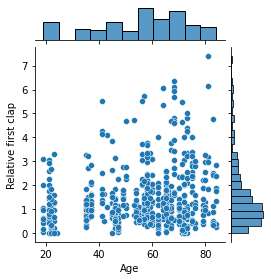

       names    coef      se       T  pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.7488  0.1799  4.1621   0.0  0.0339  0.0321    0.3954   
1        Age  0.0133  0.0031  4.3042   0.0  0.0339  0.0321    0.0072   

   CI[97.5%]  
0     1.1022  
1     0.0193  

 Fan_status Relative first clap


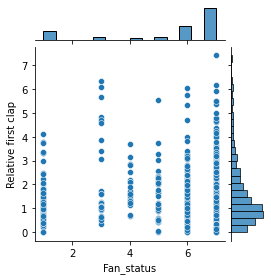

        names    coef      se        T    pval      r2  adj_r2  CI[2.5%]  \
0   Intercept  1.4163  0.1353  10.4643  0.0000  0.0007 -0.0009    1.1505   
1  Fan_status  0.0151  0.0227   0.6626  0.5078  0.0007 -0.0009   -0.0296   

   CI[97.5%]  
0     1.6820  
1     0.0597  

 Music_Exp Relative first clap


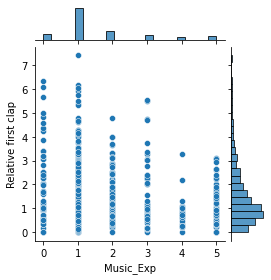

       names    coef      se        T    pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  1.6735  0.0745  22.4531  0.0000  0.0156  0.0141    1.5272   
1  Music_Exp -0.1147  0.0355  -3.2297  0.0013  0.0156  0.0141   -0.1844   

   CI[97.5%]  
0     1.8199  
1    -0.0450  

 Age Initial 8s ICI Median


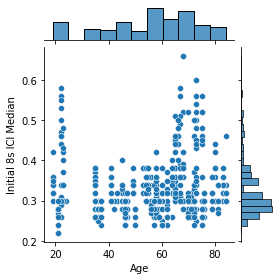

       names    coef      se        T    pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.2995  0.0103  28.9696  0.0000  0.0143  0.0125    0.2792   
1        Age  0.0005  0.0002   2.7704  0.0058  0.0143  0.0125    0.0001   

   CI[97.5%]  
0     0.3198  
1     0.0008  

 Fan_status Initial 8s ICI Median


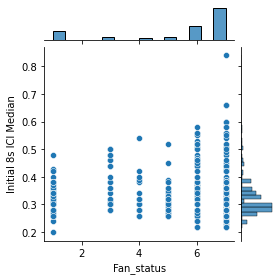

        names    coef      se        T    pval     r2  adj_r2  CI[2.5%]  \
0   Intercept  0.3323  0.0081  41.1773  0.0000  0.001 -0.0005    0.3164   
1  Fan_status -0.0011  0.0014  -0.8103  0.4181  0.001 -0.0005   -0.0038   

   CI[97.5%]  
0     0.3481  
1     0.0016  

 Music_Exp Initial 8s ICI Median


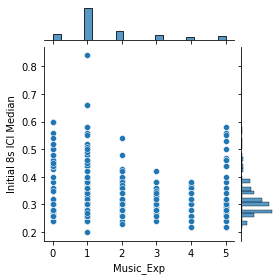

       names    coef      se        T   pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.3325  0.0045  74.7058  0.000  0.0059  0.0044    0.3238   
1  Music_Exp -0.0042  0.0021  -1.9720  0.049  0.0059  0.0044   -0.0083   

   CI[97.5%]  
0     0.3412  
1    -0.0000  

 Age ICI STD


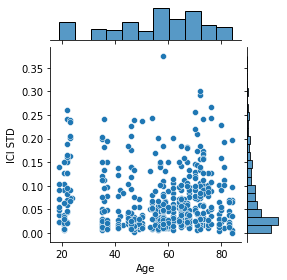

       names    coef      se       T    pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.0699  0.0090  7.7267  0.0000  0.0011 -0.0008    0.0521   
1        Age -0.0001  0.0002 -0.7546  0.4508  0.0011 -0.0008   -0.0004   

   CI[97.5%]  
0     0.0876  
1     0.0002  

 Fan_status ICI STD


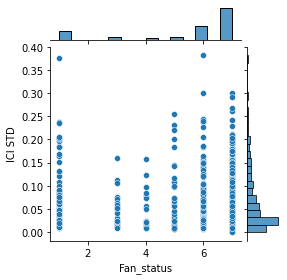

        names    coef      se       T    pval      r2  adj_r2  CI[2.5%]  \
0   Intercept  0.0637  0.0070  9.1447  0.0000  0.0001 -0.0015    0.0501   
1  Fan_status  0.0002  0.0012  0.1976  0.8434  0.0001 -0.0015   -0.0021   

   CI[97.5%]  
0     0.0774  
1     0.0025  

 Music_Exp ICI STD


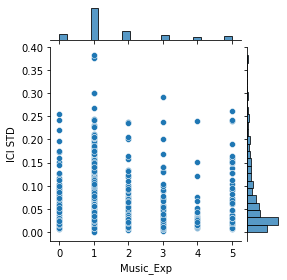

       names    coef      se        T    pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.0661  0.0039  17.0218  0.0000  0.0003 -0.0012    0.0585   
1  Music_Exp -0.0008  0.0018  -0.4257  0.6705  0.0003 -0.0012   -0.0044   

   CI[97.5%]  
0     0.0737  
1     0.0028  


In [141]:
clappingpar = ['Relative first clap','Initial 8s ICI Median','ICI STD'] # Nothing in 'Clap Count','ICI Median',
partpar = ['Age','Fan_status','Music_Exp']

for cl in clappingpar:
    for pp in partpar:
        print(' '.join(['\n',pp,cl]))
        # ----> 9         g = sns.jointplot(x=pp, y=cl, data=music_clapperings,
#         g = sns.jointplot(x=pp, y=cl, data=music_clapperings.loc[music_clapperings[pp].notna(),:],
#                   kind="reg", truncate=False,
#                   color="m", height=4)
#         sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")
        sns.jointplot(data=music_clapperings.loc[music_clapperings[pp].notna(),:], x=pp, y=cl, height=4)
    #kind="reg", truncate=False, color="m",
#       rated_clapperings.plot(x = pp,y = cl) # 'type='scatter')
        plt.show()
        lm = pg.linear_regression(music_clapperings[pp],music_clapperings[cl],remove_na=True)
        print(lm.round(4))


In [116]:
music_clapperings

,Type,Type_M,Instance,Time,Event_tag,Participant,Age,Gender,Musicianship,Fan_status,...,Clap Count,ICI Median,Average Rate,ICI STD,ICI quartiles,Relative first clap,Relative last clap,Initial 8s ICI Median,Initial 8s ICI quartiles,Music_Exp
232,Music,Music,4,1610.6,Beethoven,ADQ001,60.0,Woman,Music-loving nonmusician,7.0,...,114,0.28,217.136775,0.024912,0.0200,1.26,-5.12,0.25,4.000000e-02,1
233,Music,Music,4,1610.6,Beethoven,ADQ003,46.0,Man,Music-loving nonmusician,7.0,...,122,0.25,238.805970,0.012019,0.0200,0.60,-10.76,0.24,6.661338e-16,1
234,Music,Music,4,1610.6,Beethoven,ADQ004,57.0,Man,Music-loving nonmusician,7.0,...,124,0.30,194.466403,0.045681,0.0500,0.72,-1.68,0.28,2.000000e-02,1
235,Music,Music,4,1610.6,Beethoven,ADQ005,47.0,Man,Serious amateur musician,7.0,...,96,0.32,191.279887,0.026367,0.0200,0.20,-5.56,0.28,4.000000e-02,3
236,Music,Music,4,1610.6,Beethoven,ADQ006,58.0,Man,Music-loving nonmusician,1.0,...,118,0.34,183.529412,0.035210,0.0400,1.68,-2.48,0.28,2.000000e-02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,Music,Music,6,3282.6,Schnittke,AEQ085,NaN,Man,Amateur musician,4.0,...,99,0.45,136.138029,0.123299,0.1600,2.12,-4.04,0.39,1.650000e-01,2
434,Music,Music,6,3282.6,Schnittke,AEQ087,NaN,Woman,Music-loving nonmusician,7.0,...,159,0.27,217.895919,0.021988,0.0200,2.60,-1.28,0.28,2.000000e-02,1
435,Music,Music,6,3282.6,Schnittke,AEQ088,NaN,Man,Semiprofessional musician,6.0,...,186,0.32,196.856907,0.035292,0.0550,1.08,-1.36,0.24,2.000000e-02,4
436,Music,Music,6,3282.6,Schnittke,AEQ089,23.0,Woman,Amateur musician,1.0,...,76,0.51,111.622074,0.203951,0.2000,3.32,-1.86,0.34,1.500000e-01,2



 KM Relative first clap


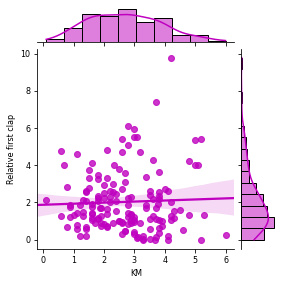

       names    coef      se       T   pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  1.8764  0.3304  5.6795  0.000  0.0017 -0.0049    1.2237   
1         KM  0.0570  0.1128  0.5054  0.614  0.0017 -0.0049   -0.1659   

   CI[97.5%]  
0     2.5290  
1     0.2799  

 KM Initial 8s ICI Median


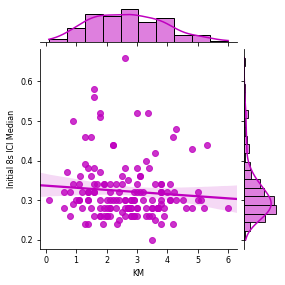

       names    coef      se        T    pval     r2  adj_r2  CI[2.5%]  \
0  Intercept  0.3365  0.0150  22.3997  0.0000  0.007  0.0004    0.3068   
1         KM -0.0053  0.0052  -1.0320  0.3038  0.007  0.0004   -0.0156   

   CI[97.5%]  
0     0.3662  
1     0.0049  

 KM ICI STD


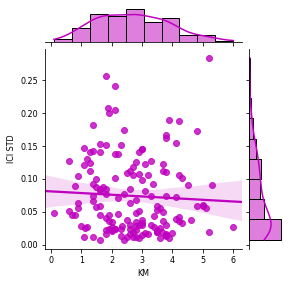

       names    coef      se       T    pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.0809  0.0116  6.9484  0.0000  0.0027 -0.0038    0.0579   
1         KM -0.0026  0.0040 -0.6430  0.5212  0.0027 -0.0038   -0.0104   

   CI[97.5%]  
0     0.1039  
1     0.0053  

 AWE Relative first clap


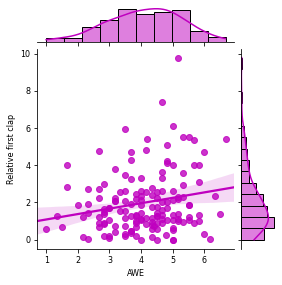

       names    coef      se       T    pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.7941  0.4953  1.6035  0.1110  0.0407  0.0342   -0.1845   
1        AWE  0.2913  0.1163  2.5056  0.0133  0.0407  0.0342    0.0616   

   CI[97.5%]  
0     1.7728  
1     0.5210  

 AWE Initial 8s ICI Median


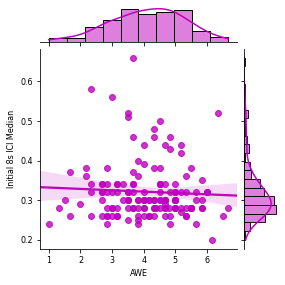

       names    coef      se        T   pval      r2  adj_r2  CI[2.5%]  \
0  Intercept  0.3352  0.0225  14.9237  0.000  0.0029  -0.004    0.2908   
1        AWE -0.0034  0.0053  -0.6479  0.518  0.0029  -0.004   -0.0139   

   CI[97.5%]  
0     0.3796  
1     0.0070  

 AWE ICI STD


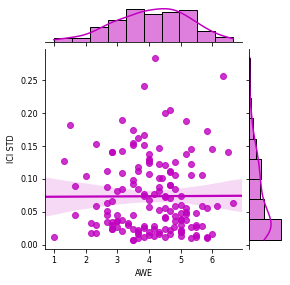

       names    coef      se       T    pval   r2  adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  0.0725  0.0177  4.1041  0.0001  0.0 -0.0067    0.0376     0.1075
1        AWE  0.0002  0.0041  0.0596  0.9526  0.0 -0.0067   -0.0080     0.0084


In [234]:
rated_clapperings=all_clapperings.loc[~pd.isnull(all_clapperings['KM']),:].copy()
#rated_clapperings=all_clapperings.loc[all_clapperings['Event_tag']=='Schnittke',:].copy()
rated_clapperings.columns
clappingpar = ['Relative first clap','Initial 8s ICI Median','ICI STD'] # Nothing in 'Clap Count','ICI Median',
partpar = ['KM', 'AWE']
for pp in partpar:
    for cl in clappingpar:
        print(' '.join(['\n',pp,cl]))
        
        g = sns.jointplot(x=pp, y=cl, data=rated_clapperings,
                  kind="reg", truncate=False,
                  color="m", height=4)
#         rated_clapperings.plot(x = pp,y = cl)# 'type='scatter')
        plt.show()
        lm = pg.linear_regression(rated_clapperings[pp],rated_clapperings[cl],remove_na=True)
        print(lm.round(4))


670
Clap Count Gender
        Source            SS  DF1  DF2             MS           F  \
0       Gender  6.102594e+03    2   59    3051.296823    1.374867   
1    Event_tag  2.262920e+06    8  472  282864.949373  465.627344   
2  Interaction  1.534656e+04   16  472     959.160118    1.578885   

           p-unc     p-GG-corr       np2       eps sphericity   W-spher  \
0   2.608549e-01           NaN  0.044530       NaN        NaN       NaN   
1  1.710363e-218  2.064671e-46  0.887539  0.199808      False  0.000002   
2   7.032848e-02           NaN  0.050802       NaN        NaN       NaN   

         p-spher  
0            NaN  
1  4.172400e-140  
2            NaN  


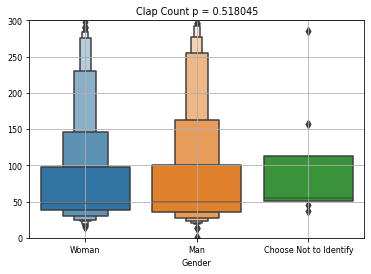

Relative first clap Gender
        Source          SS  DF1  DF2         MS          F         p-unc  \
0       Gender    1.550260    2   59   0.775130   0.124975  8.827516e-01   
1    Event_tag  149.780826    8  472  18.722603  17.577415  5.321342e-23   
2  Interaction   11.963579   16  472   0.747724   0.701988  7.929014e-01   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0           NaN  0.004219       NaN        NaN       NaN           NaN  
1  1.069711e-15  0.229538  0.637111      False  0.137086  1.712520e-10  
2           NaN  0.023243       NaN        NaN       NaN           NaN  


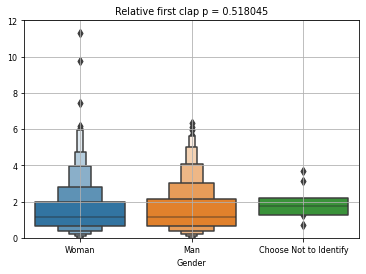

Initial 8s ICI Median Gender
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0       Gender  0.056946    2   56  0.028473  0.873152  0.423241  0.030241   
1    Event_tag  0.103200    8  448  0.012900  1.962491  0.049558  0.033858   
2  Interaction  0.071494   16  448  0.004468  0.679772  0.814796  0.023702   

        eps  
0       NaN  
1  0.231775  
2       NaN  


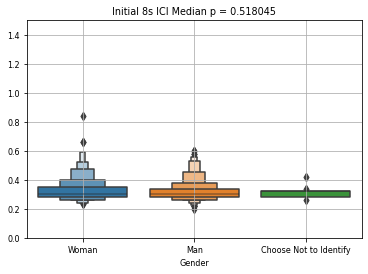

Clap Count Seat_Zone
        Source            SS  DF1  DF2             MS           F  \
0    Seat_Zone  2.367228e+04    5   56    4734.455182    2.338594   
1    Event_tag  2.262920e+06    8  448  282864.949373  457.449996   
2  Interaction  2.506132e+04   40  448     626.533012    1.013231   

           p-unc     p-GG-corr       np2       eps sphericity   W-spher  \
0   5.347352e-02           NaN  0.172735       NaN        NaN       NaN   
1  3.775221e-210  2.064671e-46  0.890934  0.199808      False  0.000002   
2   4.516694e-01           NaN  0.082962       NaN        NaN       NaN   

         p-spher  
0            NaN  
1  4.172400e-140  
2            NaN  


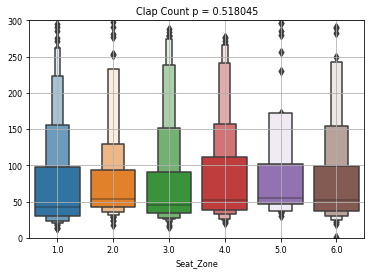

Relative first clap Seat_Zone
        Source          SS  DF1  DF2         MS          F         p-unc  \
0    Seat_Zone   56.214519    5   56  11.242904   2.022696  8.936129e-02   
1    Event_tag  149.780826    8  448  18.722603  17.215137  2.190694e-22   
2  Interaction   27.485194   40  448   0.687130   0.631805  9.623291e-01   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0           NaN  0.152972       NaN        NaN       NaN           NaN  
1  1.069711e-15  0.235131  0.637111      False  0.137086  1.712520e-10  
2           NaN  0.053399       NaN        NaN       NaN           NaN  


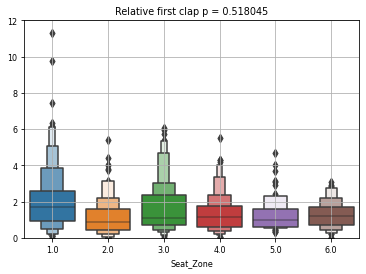

Initial 8s ICI Median Seat_Zone
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0    Seat_Zone  0.089953    5   53  0.017991  0.531754  0.751227  0.047769   
1    Event_tag  0.103200    8  424  0.012900  1.967969  0.049009  0.035802   
2  Interaction  0.237011   40  424  0.005925  0.903930  0.640692  0.078576   

        eps  
0       NaN  
1  0.231775  
2       NaN  


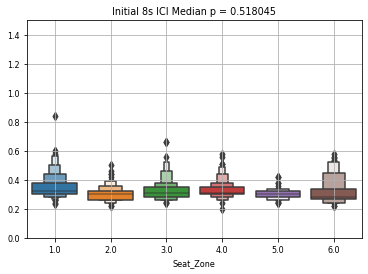

In [202]:

music_clapperings=all_clapperings.loc[all_clapperings['Type']=='Music',:].copy()
print(len(music_clapperings))

betweens = ['Gender','Seat_Zone']
test_feats = ['Clap Count','Relative first clap','Initial 8s ICI Median']

v_range = {'Clap Count':[0,300], 'Average Rate':[75,275], 'ICI Median':[0.0,1.5], 'ICI STD':[0.0,1.5], 'ICI quartiles':[0.0,1.0],
       'Initial 8s ICI Median':[0.0,1.5], 'Initial 8s ICI quartiles':[0.0,1.0],'Relative first clap':[0.0,12],'Relative last clap':[-15.0,0]} 
for b in betweens:
    for v in test_feats:
        print(v + ' ' + b)
        aov = pg.mixed_anova(dv=v, between=b,within='Event_tag', subject='Participant', data=music_clapperings)
        print(aov)

        ax_i = sns.boxenplot(x = b,y = v, data = music_clapperings)
        ax_i.set_title(v + ' p = ' + "{:.6f}".format(lm['pval'][1]))
        ax_i.set_ylim(v_range[v])
        ax_i.set_ylabel('')
        ax_i.grid()
        #plt.savefig('plots/clapping_rm_stats_'+test_feat_labels[j]+'_set.png',bbox_inches = 'tight',dpi = 300)
        plt.show()

# Familiarity and proximity on clap sequence statistics
recreate the analysis of clapping neighbours and similarity of rates 


This analysis was initially confused because of an accidental subdivition of the relationship types. Results would be significant for Relationship as a category but not for the simplified factor of familiarity. This is because there were some rare relationship categories that I had forgotten encoding like the rare "friend/stranger" for relationships that were comfirmed by one party but denied by the other in their survey responses. 

Instead of running on those early results, here and elsewhere, we depend on the simpler familiarity category for participant pairs or introduce a reduction of the relationship category to friend (according to at least one) family (partner or parent/child) and stranger.

In [13]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Part_Codes = Clap_Feats.columns
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ023,2.0,0,Stranger
2,ADQ001,ADQ024,2.0,0,Stranger
3,ADQ001,ADQ031,2.0,0,Stranger
4,ADQ001,ADQ035,2.0,0,Stranger
...,...,...,...,...,...
424,AEQ080,AEQ081,3.0,0,Stranger
425,AEQ080,AEQ089,1.0,1,Family_ParentChild
426,AEQ081,AEQ082,1.0,1,Family_Partner
427,AEQ082,AEQ087,3.0,0,Stranger


In [16]:
Sub_Rels['Related'] = ''
rels = ['Stranger','Friend','Family']
for r in rels:
    Sub_Rels.loc[Sub_Rels['Relationship'].str.startswith(r),'Related'] = r
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr,Related
0,ADQ001,ADQ006,3.0,0,Stranger,-0.191238,Stranger
1,ADQ001,ADQ023,2.0,0,Stranger,0.175272,Stranger
2,ADQ001,ADQ024,2.0,0,Stranger,0.091366,Stranger
3,ADQ001,ADQ031,2.0,0,Stranger,0.328420,Stranger
4,ADQ001,ADQ035,2.0,0,Stranger,0.051259,Stranger
...,...,...,...,...,...,...,...
424,AEQ080,AEQ081,3.0,0,Stranger,0.204491,Stranger
425,AEQ080,AEQ089,1.0,1,Family_ParentChild,0.117081,Family
426,AEQ081,AEQ082,1.0,1,Family_Partner,-0.412821,Family
427,AEQ082,AEQ087,3.0,0,Stranger,-0.109050,Stranger


In [17]:
ClapDets=partDets.loc[partDets['Participant_Code'].isin(Clap_Feats.columns),:]
#Clap_Feats = Clap_Feats[ClapDets['Participant_Code']]
Clap_Feats.fillna(0,inplace = True)
#Clap_Feats

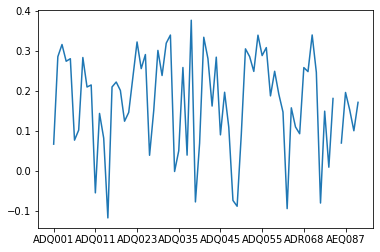

In [28]:
# generate Clap_Feats per appaluse event

A = Clap_Feats.corr(method = 'spearman')
A.median().plot()

# build a data frame with pairwise spearman correlations as a dependent variable
Sub_Rels['Seg_Corr'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [29]:
pg.anova(dv="Seg_Corr",between = ["Distance","Related"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.088091,2.0,0.044046,0.773118,0.462226,0.003659
1,Related,0.131427,2.0,0.065714,1.153452,0.316541,0.005450
2,Distance * Related,0.121768,4.0,0.030442,0.534337,0.710579,0.005051
3,Residual,23.984927,421.0,0.056971,NaN,NaN,NaN


               Source         SS     DF        MS         F     p-unc  \
0            Distance   0.088091    2.0  0.044046  0.773118  0.462226   
1             Related   0.131427    2.0  0.065714  1.153452  0.316541   
2  Distance * Related   0.121768    4.0  0.030442  0.534337  0.710579   
3            Residual  23.984927  421.0  0.056971       NaN       NaN   

        np2  
0  0.003659  
1  0.005450  
2  0.005051  
3       NaN  
    Source  ddof1  ddof2         F   p-unc       np2
0  Related      2    426  1.250537  0.2874  0.005837
    Source  ddof1  ddof2         F   p-unc       np2
0  Related      2     36  1.349798  0.2721  0.069758


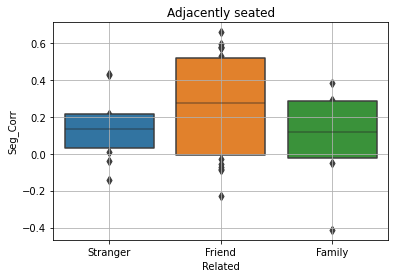

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    426  1.339802  0.262999  0.006251
     Source  ddof1  ddof2         F     p-unc      np2
0  Distance      2    370  0.294612  0.744995  0.00159


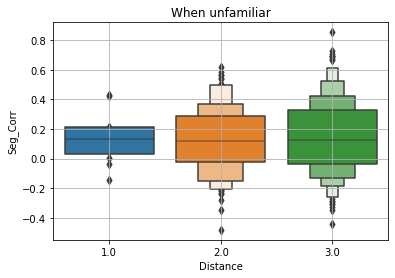

In [30]:
aov = pg.anova(dv="Seg_Corr",between = ["Distance","Related"], data=Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
aov = pg.anova(dv="Seg_Corr",between = ["Related"], data=Sub_Rels)
print(aov)
aov = pg.anova(dv="Seg_Corr",between = "Related", data=Sub_Sub_Rels)
print(aov)
sns.boxenplot(x = "Related",y = 'Seg_Corr', order = rels, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.grid()
plt.show()


Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
aov = pg.anova(dv="Seg_Corr",between = ['Distance'], data=Sub_Rels)
print(aov)
aov = pg.anova(dv="Seg_Corr",between = 'Distance', data=Sub_Sub_Rels)
print(aov)
sns.boxenplot(x = 'Distance',y = 'Seg_Corr', data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.grid()
plt.show()

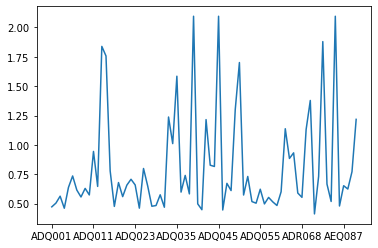

In [31]:
# Euclidian distance metric
sub_Claps = Clap_Feats.loc[0:20] # 10 seconds during which participants clapped indepnendently
A = pd.DataFrame(squareform(pdist(sub_Claps.T)), columns = sub_Claps.columns, index = sub_Claps.columns)
A.median().plot()

# build a data frame with pairwise spearman correlations as a dependent variable
Sub_Rels['Seg_Dist'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Dist'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [32]:
pg.anova(dv='Seg_Dist',between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,1.980778,2.0,0.990389,2.468513,0.085930,0.011537
1,Familiarity,0.831075,1.0,0.831075,2.071427,0.150821,0.004873
2,Distance * Familiarity,0.486666,2.0,0.243333,0.606499,0.545730,0.002859
3,Residual,169.711287,423.0,0.401209,NaN,NaN,NaN


In [33]:
pg.anova(dv='Seg_Dist',between = ["Distance","Related"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.476104,2.0,0.238052,0.592146,5.535989e-01,0.002805
1,Related,25.760671,2.0,12.880335,32.039372,1.116616e-13,0.132100
2,Distance * Related,2.367172,4.0,0.591793,1.472064,2.097476e-01,0.013793
3,Residual,169.248675,421.0,0.402016,NaN,NaN,NaN


               Source          SS     DF         MS          F         p-unc  \
0            Distance    0.476104    2.0   0.238052   0.592146  5.535989e-01   
1             Related   25.760671    2.0  12.880335  32.039372  1.116616e-13   
2  Distance * Related    2.367172    4.0   0.591793   1.472064  2.097476e-01   
3            Residual  169.248675  421.0   0.402016        NaN           NaN   

        np2  
0  0.002805  
1  0.132100  
2  0.013793  
3       NaN  
    Source  ddof1  ddof2         F     p-unc       np2
0  Related      2     36  0.205026  0.815571  0.011262


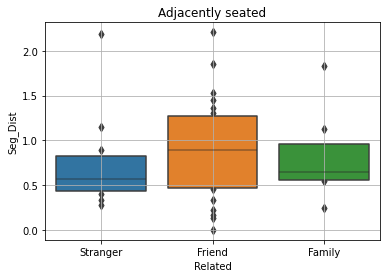

    Source  ddof1  ddof2   F     p-unc       np2
0  Related    NaN    NaN NaN  0.327467  0.003894


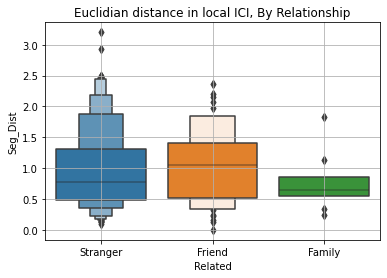

     Source  ddof1  ddof2         F     p-unc      np2
0  Distance      2    426  1.516703  0.220617  0.00707
     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    370  0.853431  0.426788  0.004592


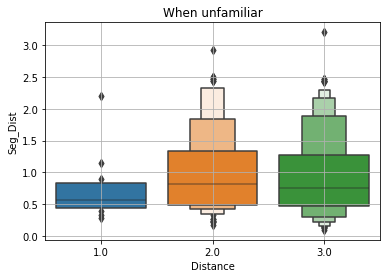

In [37]:
aov = pg.anova(dv='Seg_Dist',between = ["Distance","Related"], data=Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
aov = pg.anova(dv='Seg_Dist',between = "Related", data=Sub_Sub_Rels)
print(aov)
sns.boxenplot(x = "Related",y = 'Seg_Dist', order = rels, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.grid()
plt.show()
aov = pg.welch_anova(dv='Seg_Dist',between = ["Related"], data=Sub_Rels)
print(aov)
sns.boxenplot(x = "Related",y = 'Seg_Dist', order = rels, data = Sub_Rels)
plt.title('Euclidian distance in local ICI, By Relationship')
plt.grid()
plt.show()


Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
aov = pg.anova(dv='Seg_Dist',between = ['Distance'], data=Sub_Rels)
print(aov)
aov = pg.anova(dv='Seg_Dist',between = 'Distance', data=Sub_Sub_Rels)
print(aov)
sns.boxenplot(x = 'Distance',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.grid()
plt.show()

In [54]:
#Relationship, Relationship_number, Distance, Familiarity,Event_tag,Type,First_diff,Last_diff,ICI_Median_diff
colums = ['Related','Relationship_number','Distance']
clap_case = pd.DataFrame()
events = list(all_clapperings['Event_tag'].unique())
for e in events:
    clapperings = all_clapperings.loc[all_clapperings['Event_tag']==e,:]
    # build a data frame with pairwise spearman correlations as a dependent variable
    Part_Codes = clapperings.loc[:,'Participant'].unique()
    Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
    Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index()
    Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0
    New_Rels = Sub_Rels.copy()
    New_Rels['Event'] = e
    New_Rels['Type'] = clapperings.iloc[0,0]
    
    for i,row in Sub_Rels.iterrows():
        for tag in ['ICI Median','Initial 8s ICI Median','Initial 8s ICI quartiles','Relative first clap', 'Relative last clap']:
            New_Rels.loc[i,tag] = abs(clapperings.loc[clapperings['Participant']==row['Participant_Code_1'],tag].values-clapperings.loc[clapperings['Participant']==row['Participant_Code_2'],tag].values)[0]
            
    clap_case = pd.concat([clap_case,New_Rels],axis=0)
    
clap_case.reset_index(drop = True,inplace=True)

In [55]:
clap_case['Related'] = ''
rels = ['Stranger','Friend','Family']
for r in rels:
    clap_case.loc[clap_case['Relationship'].str.startswith(r),'Related'] = r
clap_case

,index,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Event,Type,ICI Median,Initial 8s ICI Median,Initial 8s ICI quartiles,Relative first clap,Relative last clap,Related
0,0,ADQ001,ADQ006,3.0,0,Stranger,Entre 1,Entrance,0.055,0.06,0.015,0.82,0.88,Stranger
1,1,ADQ001,ADQ021,3.0,0,Stranger,Entre 1,Entrance,0.040,0.05,0.005,4.44,0.60,Stranger
2,2,ADQ001,ADQ023,2.0,0,Stranger,Entre 1,Entrance,0.020,0.03,0.010,5.06,0.72,Stranger
3,3,ADQ001,ADQ024,2.0,0,Stranger,Entre 1,Entrance,0.080,0.12,0.065,4.04,2.20,Stranger
4,4,ADQ001,ADQ031,2.0,0,Stranger,Entre 1,Entrance,0.060,0.06,0.020,3.30,0.20,Stranger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6116,630,AEQ080,AEQ081,3.0,0,Stranger,Finale,Music,0.140,0.01,0.020,0.12,66.02,Stranger
6117,632,AEQ080,AEQ089,1.0,1,Family_ParentChild,Finale,Music,0.040,0.08,0.035,0.32,60.62,Family
6118,633,AEQ081,AEQ082,1.0,1,Family_Partner,Finale,Music,0.050,0.03,0.020,0.22,0.16,Family
6119,636,AEQ082,AEQ087,3.0,0,Stranger,Finale,Music,0.020,0.06,0.010,0.36,0.42,Stranger


In [48]:
aov = pg.ancova(data = clap_case, dv=tag, covar='Distance', between='Related')
print(aov)

     Source             SS    DF         F     p-unc       np2
0   Related     335.307230     2  3.288881  0.037362  0.001074
1  Distance      74.465152     1  1.460792  0.226851  0.000239
2  Residual  311819.482843  6117       NaN       NaN       NaN


In [49]:
aov = pg.welch_anova(data = clap_case, dv=tag,between=['Distance'])
print(aov)

     Source  ddof1  ddof2   F     p-unc       np2
0  Distance    NaN    NaN NaN  0.263321  0.000222


In [51]:
tag

'Relative last clap'

In [52]:
pg.anova(dv=tag, between=['Familiarity','Distance'], data=clap_case)


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,313.320449,1.0,313.320449,6.169700,0.013022,0.001008
1,Distance,288.354941,2.0,144.177471,2.839048,0.058558,0.000928
2,Familiarity * Distance,1251.260247,2.0,625.630123,12.319496,0.000005,0.004013
3,Residual,310542.583176,6115.0,50.783742,NaN,NaN,NaN


                   Source         SS      DF        MS          F     p-unc  \
0             Familiarity   0.113471     1.0  0.113471  20.203899  0.000007   
1                Distance   0.072255     2.0  0.036128   6.432645  0.001619   
2  Familiarity * Distance   0.006281     2.0  0.003141   0.559180  0.571707   
3                Residual  34.208947  6091.0  0.005616        NaN       NaN   

        np2  
0  0.003306  
1  0.002108  
2  0.000184  
3       NaN  
ICI Median

        Source  ddof1  ddof2        F     p-unc       np2
0  Familiarity      1   6095  9.57466  0.001982  0.001568
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    545  7.046513  0.008174  0.012764
        Source  ddof1  ddof2         F    p-unc       np2
0  Familiarity      1   5548  14.65579  0.00013  0.002635
     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6094  1.122492  0.325535  0.000368
     Source  ddof1  ddof2         F     p-unc       np2
0  D

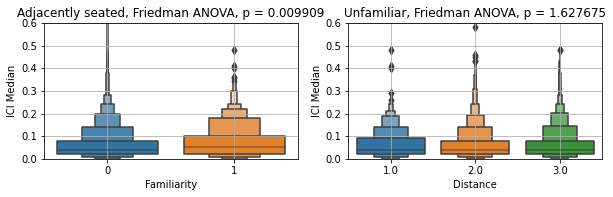

                   Source          SS      DF        MS          F     p-unc  \
0             Familiarity    0.571977     1.0  0.571977  13.033081  0.000309   
1                Distance    0.161510     2.0  0.080755   1.840081  0.158895   
2  Familiarity * Distance    0.156852     2.0  0.078426   1.787014  0.167549   
3                Residual  261.081328  5949.0  0.043887        NaN       NaN   

        np2  
0  0.002186  
1  0.000618  
2  0.000600  
3       NaN  
Initial 8s ICI Median

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   5953  9.679228  0.001872  0.001623
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    531  0.003568  0.952388  0.000007
        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   5420  17.301218  0.000032  0.003182
     Source  ddof1  ddof2         F    p-unc       np2
0  Distance      2   5952  0.165422  0.84754  0.000056
     Source  ddof1  ddof2         F     

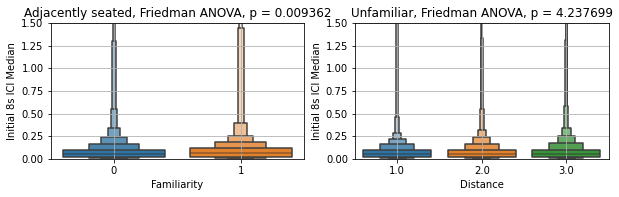

                   Source          SS      DF        MS         F     p-unc  \
0             Familiarity    0.471861     1.0  0.471861  7.203095  0.007298   
1                Distance    0.182941     2.0  0.091470  1.396323  0.247586   
2  Familiarity * Distance    0.348936     2.0  0.174468  2.663301  0.069801   
3                Residual  389.707823  5949.0  0.065508       NaN       NaN   

        np2  
0  0.001209  
1  0.000469  
2  0.000895  
3       NaN  
Initial 8s ICI quartiles

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   5953  4.556953  0.032826  0.000765
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    531  0.119929  0.729249  0.000226
        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   5420  10.259429  0.001368  0.001889
     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   5952  0.074709  0.928014  0.000025
     Source  ddof1  ddof2         F    p

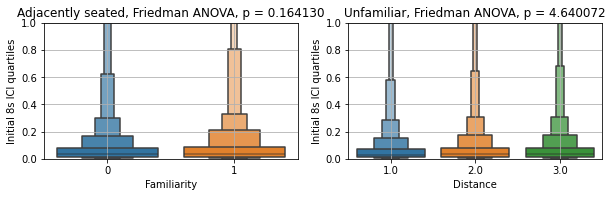

                   Source            SS      DF         MS         F  \
0             Familiarity      9.450595     1.0   9.450595  0.669997   
1                Distance     13.883146     2.0   6.941573  0.492121   
2  Familiarity * Distance     30.391455     2.0  15.195727  1.077296   
3                Residual  86254.692991  6115.0  14.105428       NaN   

      p-unc       np2  
0  0.413085  0.000110  
1  0.611353  0.000161  
2  0.340580  0.000352  
3       NaN       NaN  
Relative first clap

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   6119  0.136247  0.712053  0.000022
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    547  0.243504  0.621885  0.000445
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   5570  1.369824  0.241892  0.000246
     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6118  0.225243  0.798329  0.000074
     Source  ddof1  ddof2       

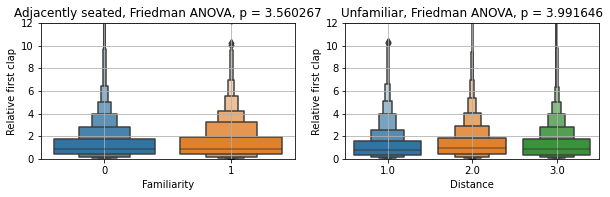

                   Source             SS      DF          MS          F  \
0             Familiarity     313.320449     1.0  313.320449   6.169700   
1                Distance     288.354941     2.0  144.177471   2.839048   
2  Familiarity * Distance    1251.260247     2.0  625.630123  12.319496   
3                Residual  310542.583176  6115.0   50.783742        NaN   

      p-unc       np2  
0  0.013022  0.001008  
1  0.058558  0.000928  
2  0.000005  0.004013  
3       NaN       NaN  
Relative last clap

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   6119  1.845802  0.174323  0.000302
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    547  0.144847  0.703657  0.000265
        Source  ddof1  ddof2         F   p-unc       np2
0  Familiarity      1   5570  7.959548  0.0048  0.001427
     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6118  0.677986  0.507676  0.000222
     Source  ddof1  dd

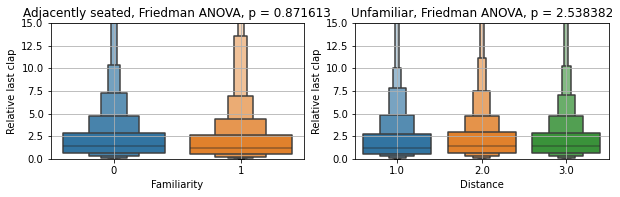

In [57]:
v_range = {'Clap Count':[0,300], 'Average Rate':[75,275], 'ICI Median':[0.0,0.6], 'ICI STD':[0.0,1.5], 'ICI quartiles':[0.0,1.0],
       'Initial 8s ICI Median':[0.0,1.5], 'Initial 8s ICI quartiles':[0.0,1.0],'Relative first clap':[0.0,12],'Relative last clap':[0,15]}

for tag in ['ICI Median','Initial 8s ICI Median','Initial 8s ICI quartiles','Relative first clap', 'Relative last clap']:
    aov = pg.anova(dv=tag, between=['Familiarity','Distance'], data=clap_case) #aov = pg.ancova(data = clap_case, dv=tag, covar='Distance', between='Familiarity')
    print(aov)
    print(tag + '\n')
    f, a = plt.subplots(1,2,figsize=(10,2.5)) 
    ax_i = a[0]
    aov = pg.anova(dv=tag,between = ["Familiarity"], data=clap_case)
    print(aov)
    Sub_Sub_Rels = clap_case[clap_case['Distance'] == 1.0]
    aov2 = pg.anova(dv=tag,between = "Familiarity", data=Sub_Sub_Rels)
    print(aov2)
    Sub_Sub_Rels = clap_case[clap_case['Distance'] > 1.0]
    aov2 = pg.anova(dv=tag,between = "Familiarity", data=Sub_Sub_Rels)
    print(aov2)
    sns.boxenplot(x = "Familiarity",y = tag, data = clap_case,ax = ax_i)
    ax_i.set_ylim(v_range[tag])
    ax_i.set_title('Adjacently seated, Friedman ANOVA, p = ' + "{:.6f}".format(aov['p-unc'].values[0]*5))

    ax_i.grid()
    
    ax_i = a[1]
    Sub_Sub_Rels = clap_case[clap_case['Familiarity'] == 0]
    aov = pg.anova(dv=tag,between = ['Distance'], data=clap_case)
    print(aov)
    aov2 = pg.anova(dv=tag,between = 'Distance', data=Sub_Sub_Rels)
    print(aov2)
    sns.boxenplot(x = 'Distance',y = tag, data = clap_case,ax = ax_i)
    ax_i.set_ylim(v_range[tag])
    ax_i.set_title('Unfamiliar, Friedman ANOVA, p = ' + "{:.6f}".format(aov['p-unc'].values[0]*5))

    ax_i.grid()
    plt.show()

                   Source         SS      DF        MS          F     p-unc  \
0             Familiarity   0.113471     1.0  0.113471  20.203899  0.000007   
1                Distance   0.072255     2.0  0.036128   6.432645  0.001619   
2  Familiarity * Distance   0.006281     2.0  0.003141   0.559180  0.571707   
3                Residual  34.208947  6091.0  0.005616        NaN       NaN   

        np2  
0  0.003306  
1  0.002108  
2  0.000184  
3       NaN  
ICI Median

        Source  ddof1  ddof2          F     p-unc      np2
0  Familiarity      1   3752  13.670152  0.000221  0.00363
        Source  ddof1  ddof2         F     p-unc      np2
0  Familiarity      1   1794  2.011854  0.156248  0.00112
        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    545  7.046513  0.008174  0.012764


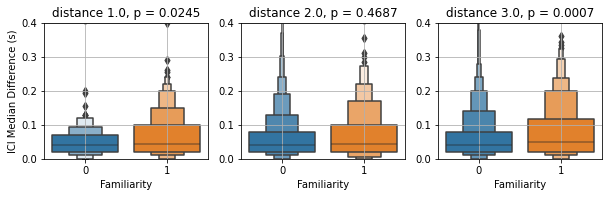

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   5255  3.036936  0.048066  0.001154
     Source  ddof1  ddof2         F     p-unc      np2
0  Distance      2    685  1.537748  0.215605  0.00447
     Source  ddof1  ddof2        F     p-unc      np2
0  Distance      1    149  4.96223  0.027406  0.03223


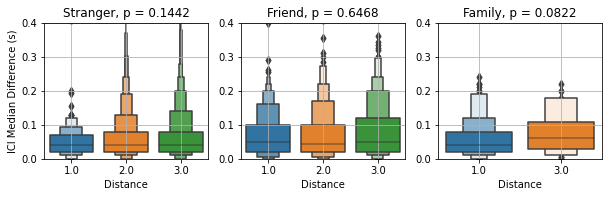

In [335]:
v_range = {'Clap Count':[0,300], 'Average Rate':[75,275], 'ICI Median':[0.0,0.4], 'ICI STD':[0.0,1.5], 'ICI quartiles':[0.0,1.0],
       'Initial 8s ICI Median':[0.0,1.5], 'Initial 8s ICI quartiles':[0.0,1.0],'Relative first clap':[0.0,12],'Relative last clap':[0,15]}

tag = 'ICI Median'#,'Initial 8s ICI quartiles','Relative first clap', 'Relative last clap']:
aov = pg.anova(dv=tag, between=['Familiarity','Distance'], data=clap_case) #aov = pg.ancova(data = clap_case, dv=tag, covar='Distance', between='Familiarity')
print(aov)
print(tag + '\n')

f, a = plt.subplots(1,3,figsize=(10,2.5))
for d in clap_case['Distance'].unique():
    ax_i = a[int(d-1)]
    Sub_Sub_Rels = clap_case[clap_case['Distance'] == d]
    aov = pg.anova(dv=tag,between = "Familiarity", data=Sub_Sub_Rels)
    print(aov)
    sns.boxenplot(x = "Familiarity",y = tag, data = Sub_Sub_Rels,ax = ax_i)
    ax_i.set_ylim(v_range[tag])
    ax_i.set_title('distance ' + str(d)+', p = ' + "{:.4f}".format(aov['p-unc'].values[0]*3))
    ax_i.set_ylabel('')
    ax_i.grid()
a[0].set_ylabel('ICI Median Difference (s)')
plt.savefig('plots/Familiarity_distance_ICIMediandiff_set.png',bbox_inches = 'tight',dpi = 300)
plt.show()

rels = ['Stranger','Friend','Family']
f, a = plt.subplots(1,len(rels),figsize=(10,2.5))

for d in range(len(rels)):
    ax_i = a[d]
    rel=rels[d]
    Sub_Sub_Rels = clap_case.loc[clap_case['Relationship'].str.startswith(rel),:]
    aov = pg.anova(dv=tag,between = "Distance", data=Sub_Sub_Rels)
    print(aov)
    sns.boxenplot(x = "Distance",y = tag, data = Sub_Sub_Rels,ax = ax_i)
    ax_i.set_ylim(v_range[tag])
    ax_i.set_title(rel+', p = ' + "{:.4f}".format(aov['p-unc'].values[0]*3))
    ax_i.set_ylabel('')
    ax_i.grid()
a[0].set_ylabel('ICI Median Difference (s)')
plt.savefig('plots/Distance_Relationship_ICIMediandiff_set.png',bbox_inches = 'tight',dpi = 300)
plt.show()

Small effect of familiarity, with people who know each other clapping at slightly more distinct rates than strangers. No strong effect of proximity. 

In [336]:
aov = pg.anova(dv=tag, between=['Familiarity','Distance','Type'], data=clap_case) #aov = pg.ancova(data = clap_case, dv=tag, covar='Distance', between='Familiarity')
print(aov)

                          Source         SS      DF        MS          F  \
0                    Familiarity   0.111369     1.0  0.111369  19.898528   
1                       Distance   0.072647     2.0  0.036323   6.489945   
2                           Type   0.134941     2.0  0.067471  12.055086   
3         Familiarity * Distance   0.005870     2.0  0.002935   0.524362   
4             Familiarity * Type   0.011445     2.0  0.005722   1.022447   
5                Distance * Type   0.008260     4.0  0.002065   0.368962   
6  Familiarity * Distance * Type   0.021400     4.0  0.005350   0.955875   
7                       Residual  34.023339  6079.0  0.005597        NaN   

      p-unc       np2  
0  0.000008  0.003263  
1  0.001529  0.002131  
2  0.000006  0.003950  
3  0.591960  0.000172  
4  0.359776  0.000336  
5  0.830900  0.000243  
6  0.430500  0.000629  
7       NaN       NaN  


## Characterising Synchronous applause

With these examples of individual clapping sequences, we can also look at how they coordinate with each other. This audience was visibly and audibly synchronised in part of the last round of applause and they seemed to partially synchronise at two earlier instances of applause. This section captions this convergence of clapping rates and compares the timing of applause texture changes to the events on stage, arguing for a communicative function of audience clapping synchronisation and divergence.

In [70]:
#df_motion.index=(pd.to_datetime(df_motion.index))
applause_times = pd.read_csv('./data/Applause_stage_events_T2.csv',sep=",") #SV alignment for beeps

# need to add datetime
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

applause_times['datetime'] = Synch_time + pd.to_timedelta(applause_times['concert_time'],'s')
#applause_times

In [71]:
# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
thisround = applause_times.loc[applause_times['Applause_N']==15,:].reset_index(drop=True)
# TIME LABEL
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[1:,'concert_time']-thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values#+25
musician_times['LABEL'] = thisround['Event']
musician_times['Actors'] = thisround['Actor']
musician_times = musician_times.loc[musician_times['Actors'].str.startswith('Musici'),:]
musician_times

,TIME,LABEL,Actors
3,0.0,Start to stand,Musicians
4,1.0,All standing,Musicians
5,4.0,Bow 1,Musicians
6,11.0,Bow 2,Musicians
7,17.0,Turn to de-equip,Musicians
9,19.0,De-equiping,Musicians
11,32.2,Bow 3,Musicians
12,42.2,Bow 4,Musicians
13,45.2,Start to leave,Musicians
14,55.2,Off stage,Musicians


In [72]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[14,'files'],index_col=0)
#peaks = pd.read_csv(claps_folder + '/final_peaks.csv',index_col=0)
df_claps = peaks.fillna(0)

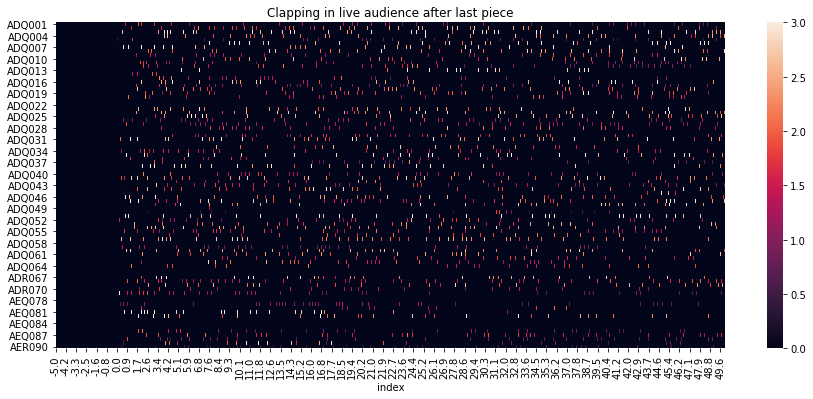

In [73]:
fig, ax = plt.subplots(figsize = [15,6])
chart = sns.heatmap(data=df_claps.loc[:50,:].transpose(), ax=ax,vmin=0, vmax=3)

plt.title('Clapping in live audience after last piece')
ax.set_xticklabels([])
ax.set_xticklabels(np.round(0+df_claps.iloc[ax.get_xticks()].index,1))
#plt.savefig('claps_finale_indiv.png',dpi=800)
plt.show()

# this visualisation does not necessarily show all claps, nor is it easy to interpret their alignment.
# use activity levels instead.

In [74]:
# build database of clapping stats over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
#sampletimes = np.array([10, 14, 18, 20, 35, 50, 65, 80, 104,108,112]) # sampletimes-5
sampletimes = np.array([3, 8, 12, 13, 28, 35, 44, 50, 78, 85, 90,100])
sampleconditions = ['Initial','Initial','Initial','Initial','Synched','Synched','Synched','Synched','End','End','End','End']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        #if len(ici)>0:
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':np.nan, 'ICI_Quartiles':np.nan, 
           'ICI_Mean':np.nan, 'ICI_STD':np.nan, 'Clap_Count':len(ici)}
        if len(ici)>3:
            these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}    
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)
    
# to_numeric
cols = ['ICI_Mean','ICI_Median','ICI_Quartiles','ICI_STD']
for c in cols:
    Clap_Style.loc[:,c] = pd.to_numeric(Clap_Style[c])

In [75]:
# clear out nans in case they make the functions panic
cstats = Clap_Style.where(Clap_Style['Clap_Count']>0)
cstats = cstats.dropna()

In [76]:
Clap_Style['ICI_Median'].sum()

261.67000000000024

ICI_Median
                      Source      W  ddof1    ddof2      F  p-unc
Friedman  Interval_condition  0.094  1.968  122.032  6.431  0.002


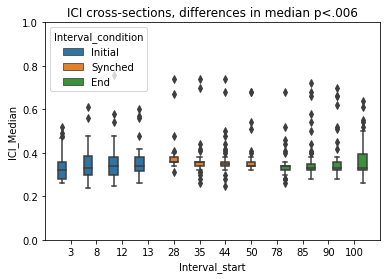


ICI_Quartiles
                      Source      W  ddof1    ddof2       F  p-unc
Friedman  Interval_condition  0.146  1.968  122.032  10.595    0.0


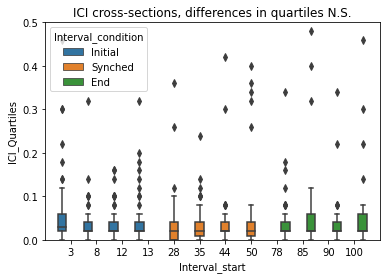

In [352]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('ICI_Median')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.xlim([-1,12])
plt.title('ICI cross-sections, differences in median p<.006')
plt.savefig('./plots/Intervals_Xsec_Medians.png',dpi=400)

plt.show()
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('\nICI_Quartiles')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.xlim([-1,12])
plt.title('ICI cross-sections, differences in quartiles N.S.')
plt.savefig('./plots/Intervals_Xsec_Quartiles.png',dpi=400)
plt.show()

This demonstrates that the clapping does seem to change in rate marginally for some applause periods, and there is a visible change in variance across participants during the synchronous clapping interval, however there is no measured difference in variability in individuals clapping over this interval.

This means that prior to synchronisation, individuals clapping sequences were comparably stable or isochronous. Clapping together did not improve the regularity of the audience participants claps *according to the precision of these measurements* with a sample rate of 20 ms, very coarse for this kind of analysis. 

# Shift into synchrony
The alignment of the measurements is not quite high enough to evaluate synchronisation with phase presevered. To facilitate the identification of the transition to coordinated claping, we use instead the local median interclapinterval: the predominant interval between claps in a sliding window of 3 secondes, to capture the regularity despite fleeting outliers and deviations. 

We use the interclap interval instead of rate to simplify some manipulations. 

In [77]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[14,'files'],index_col=0)
# peaks = pd.read_csv(claps_folder + 'Applause_15_finale_peaks.csv',index_col=0)
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [78]:
(df_OnlyClaps.sum()>50).sum() # there should over 65 series with ICI feature values

68

In [79]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0,106.9-t_interval,0.5)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[25:27]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
25.0,0.37,0.33,0.37,0.38,0.38,0.4,0.38,0.38,0.38,0.38,...,0.3,0.36,NaN,NaN,NaN,0.34,0.4,0.36,NaN,0.4
25.5,0.36,0.34,0.36,0.38,0.38,0.39,0.38,0.38,0.38,0.38,...,0.3,0.39,NaN,NaN,NaN,0.34,0.38,0.36,NaN,0.38
26.0,0.36,0.34,0.36,0.38,0.36,0.38,0.38,0.38,0.38,0.37,...,0.34,0.38,NaN,NaN,NaN,0.34,0.38,0.36,NaN,0.4
26.5,0.36,0.34,0.36,0.38,0.37,0.36,0.38,0.37,0.38,0.36,...,0.36,0.37,NaN,NaN,NaN,0.33,0.36,0.36,NaN,0.41
27.0,0.36,0.38,0.36,0.38,0.37,0.36,0.36,0.36,0.38,0.36,...,NaN,0.38,NaN,NaN,NaN,0.34,0.38,0.36,NaN,0.38


The protruding lines show how many participants start a clapping sequences with a solo clap before getting into a stead rate. Also visible here is thea few people clapping at half the rate of the audience once a common rate has been established. Very neet. 

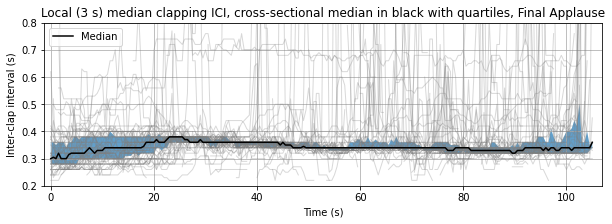

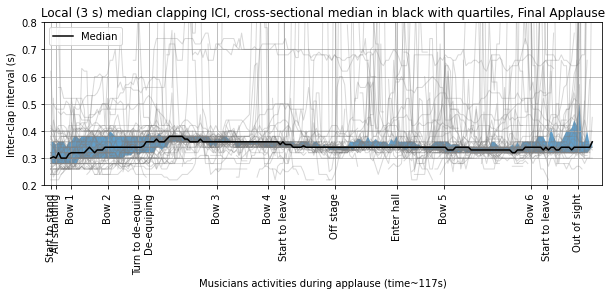

In [80]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([-1.3,106.9])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Final Applause')
plt.savefig('./plots/FinalApplause_Local_ICI_medians_QuartileTS.png',bbox_inches = 'tight',dpi=300)
plt.show()

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([-1.3,106.9])
plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=90)
plt.grid()
plt.xlabel('Musicians activities during applause (time~117s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Final Applause')
plt.savefig('./plots/FinalApplause_Local_ICI_medians_QuartileTS_MusEv.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [93]:
((1/0.32) - (1/0.37))/60

0.007038288288288289

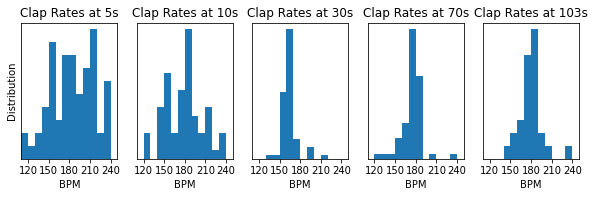

In [87]:
crosses = [5,10,30,70,103]
f, a = plt.subplots(1,len(crosses),figsize=(10,2.5))

binning = np.arange(110,250,10)
for d in range(len(crosses)):
    ax_i = a[d]
    rel=crosses[d]
    (60/Clap_Feats.loc[rel]).hist(bins = binning, ax = ax_i)
    ax_i.set_xlim([110,250])
    ax_i.set_xticks([120,150,180,210,240])
    ax_i.set_yticks([])
    ax_i.set_xlabel('BPM')
    ax_i.grid()
    ax_i.set_title('Clap Rates at ' + str(rel)+'s')
a[0].set_ylabel('Distribution')
plt.savefig('./plots/hists_syng_LocalICI_demo.png',bbox_inches = 'tight',dpi = 300)
plt.show()



73


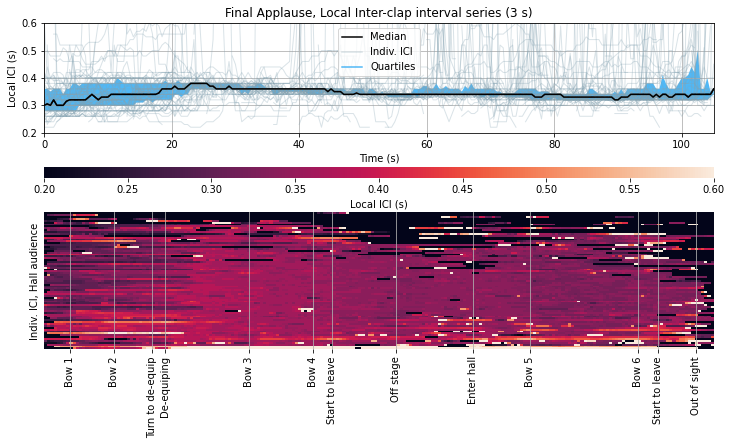

In [489]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]
grid_kws = {"height_ratios": (.4, .04, .5), "hspace": .4}
fig,(a1, cbar_ax, a2) = plt.subplots(3,1,figsize=[12,6],gridspec_kw=grid_kws)

ax = a1
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
l1, = ax.plot(df_feats['Median'],color="black",label='Median')
l2, = ax.plot([0.1,0.1],[0.2,0.2],color='xkcd:bluegrey',alpha=0.3,label='Indiv. ICI')
l3, = ax.plot([0.1,0.1],[0.2,0.2],color='xkcd:azure',alpha=0.7,label='Quartiles')
ax.legend(loc='upper left',handles=[l1, l2, l3],)

df_A.plot(linewidth=1,color='xkcd:bluegrey',alpha=0.3,legend=False,ax = ax)
ax.fill_between(x,y1,y2,facecolor='xkcd:azure',alpha = 0.7)
df_feats.plot(y='Median',color="black",legend=False,ax=ax)

ax.set_ylim([0.2,0.6])
ax.set_xlim([0,105.0])
ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Local ICI (s)')
ax.set_title('Final Applause, Local Inter-clap interval series (3 s)')

ax=a2
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600,cbar_ax=cbar_ax,
                    cbar_kws={"orientation": "horizontal","label":"Local ICI (s)"})
ax.set_ylabel('Indiv. ICI, Hall audience')
subtimes= musician_times.loc[5:20]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()

plt.savefig('./plots/FinaleApplause_mixed.png',bbox_inches = 'tight',dpi=300)
plt.show()


# contrast with Schnittke Applause

https://youtu.be/S4UVJybA6ZQ?t=5273

In [490]:
# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
thisround = applause_times.loc[applause_times['Applause_N']==6,:].reset_index(drop=True)
# TIME LABEL
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[1:,'concert_time']-thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values#+25
musician_times['LABEL'] = thisround['Event']
musician_times['Actors'] = thisround['Actor']
musician_times = musician_times.loc[musician_times['Actors'].str.startswith('Musici'),:]

cl_start = thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values
cl_end = thisround.loc[thisround['Event']=='Clapping End','concert_time'].values
cl_dur = cl_end - cl_start
musician_times

,TIME,LABEL,Actors
2,-3.7,Release instruments,Musicians
4,2.0,Stand,Musicians
5,12.0,Bow,Musicians
6,17.0,Start to leave,Musicians
8,26.0,Off stage,Musicians
10,37.0,Enter hall,Musicians
11,45.0,Bow,Musicians
12,51.0,Bow,Musicians
13,54.0,Start to leave,Musicians
15,60.1,Off stage,Musicians


In [491]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[5,'files'],index_col=0)
# peaks = pd.read_csv(claps_folder + 'Applause_6_schnittke_peaks.csv',index_col=0)
peaks_IDs = peaks.columns
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)


In [492]:
# reduce the analysis set to only those recordings with a minimum number of claps for this interval (20).
a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>20])])

# reduce analysis set to only those responses with claps detected
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>20]]
claps_ID = a[df_OnlyClaps.sum()>20] # the participant identifiers matching df_clap columns, in case of need
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)

[85, 74]


In [493]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0,cl_dur-t_interval,0.5)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[:5]

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0.0,NaN,0.58,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,NaN,NaN
0.5,0.26,0.5,NaN,NaN,NaN,0.64,0.36,NaN,NaN,NaN,...,NaN,0.52,NaN,0.3,NaN,NaN,NaN,0.24,NaN,NaN
1.0,0.26,0.39,NaN,NaN,0.44,0.47,0.36,0.32,NaN,NaN,...,NaN,0.48,NaN,0.27,NaN,NaN,NaN,0.24,NaN,NaN
1.5,0.26,0.36,0.3,NaN,0.42,0.37,0.34,0.3,NaN,NaN,...,NaN,0.38,NaN,0.27,NaN,NaN,0.32,0.24,NaN,NaN
2.0,0.26,0.32,0.3,0.36,0.4,0.3,0.34,0.29,NaN,NaN,...,0.97,0.32,NaN,0.28,NaN,0.98,0.31,0.24,NaN,0.84
2.5,0.26,0.31,0.3,0.35,0.4,0.3,0.34,0.3,0.38,0.38,...,0.29,0.38,NaN,0.28,NaN,0.42,0.29,0.24,0.3,0.6
3.0,0.26,0.3,0.3,0.35,0.39,0.3,0.33,0.3,0.26,0.38,...,0.24,0.32,NaN,0.28,NaN,0.4,0.29,0.24,0.34,0.52
3.5,0.26,0.28,0.3,0.34,0.38,0.28,0.32,0.3,0.26,0.38,...,0.26,0.26,NaN,0.28,0.58,0.4,0.29,0.24,0.4,0.52
4.0,0.26,0.28,0.3,0.35,0.38,0.27,0.32,0.3,0.26,0.38,...,0.26,0.29,NaN,0.28,0.38,0.32,0.3,0.24,0.42,0.44
4.5,0.26,0.28,0.3,0.35,0.38,0.28,0.32,0.3,0.26,0.38,...,0.26,0.29,0.38,0.3,0.35,0.3,0.28,0.24,0.43,0.44


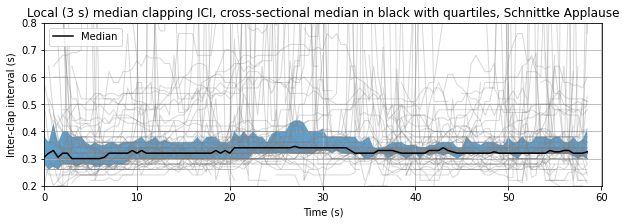

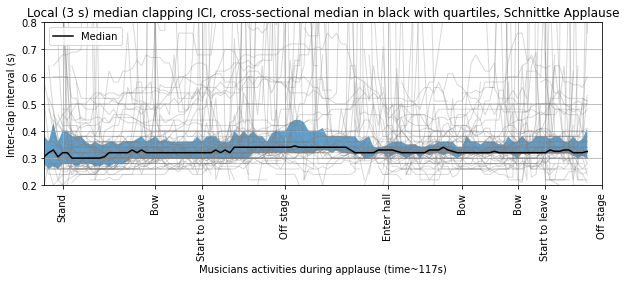

In [494]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Schnittke Applause')
plt.savefig('./plots/SchnittkeApplause_Local_ICI_medians_QuartileTS.png',bbox_inches = 'tight',dpi=300)
plt.show()



fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=90)
plt.xlim([0,cl_dur])
plt.grid()
plt.xlabel('Musicians activities during applause (time~117s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Schnittke Applause')
plt.savefig('./plots/SchnittkeApplause_Local_ICI_medians_QuartileTS_MusEv.png',bbox_inches = 'tight',dpi=300)
plt.show()

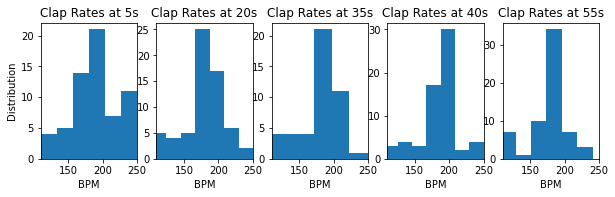

In [495]:
crosses = [5,20,35,40,55]
f, a = plt.subplots(1,len(crosses),figsize=(10,2.5))

for d in range(len(crosses)):
    ax_i = a[d]
    rel=crosses[d]
    (60/Clap_Feats.loc[rel]).hist(ax = ax_i)
    ax_i.set_xlim([110,250])
    #ax_i.set_yticks([])
    ax_i.set_xlabel('BPM')
    ax_i.grid()
    ax_i.set_title('Clap Rates at ' + str(rel)+'s')
a[0].set_ylabel('Distribution')
plt.savefig('./plots/Schnittke_hists_syng_LocalICI_demo.png',bbox_inches = 'tight',dpi = 300)
plt.show()



74


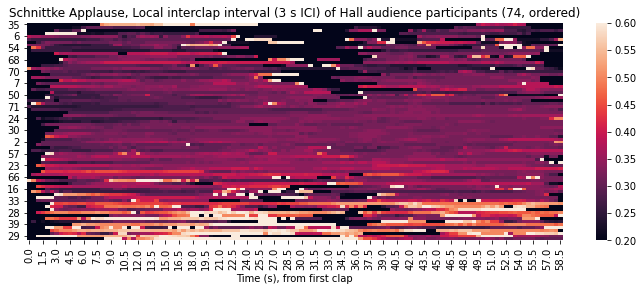

In [496]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#cm = plt.cm.get_cmap('twilight')
# df.filter(like='bbi', axis=0)

feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)
fig, ax = plt.subplots(figsize = [12,4])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Schnittke Applause, Local interclap interval (3 s ICI) of Hall audience participants (74, ordered)')
plt.xlabel('Time (s), from first clap')
ax.set_xticklabels(np.round(df_A.iloc[ax.get_xticks()].index,2))
plt.savefig('./plots/SchnittkeApplause_ICIheatT.png',bbox_inches = 'tight',dpi=300)
plt.show()


74


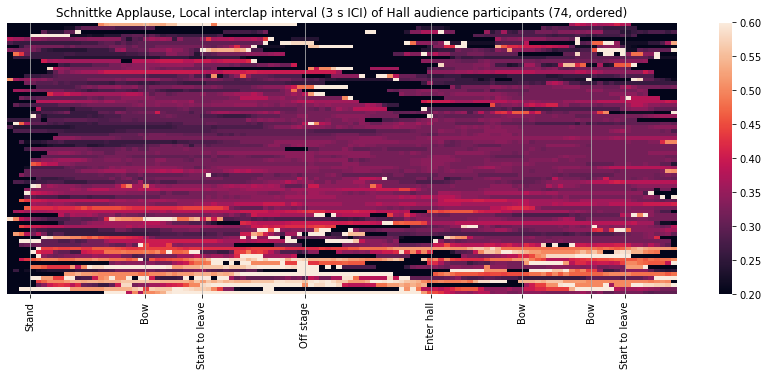

In [497]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#dists = Clap_Feats.sub(Clap_Feats.median(axis=1),axis = 0).sum()
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

fig, ax = plt.subplots(figsize = [15,5])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Schnittke Applause, Local interclap interval (3 s ICI) of Hall audience participants (74, ordered)')
#plt.xlabel('Time (s), from first clap')
#plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=45,ha='right')
subtimes= musician_times.loc[4:13]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()
plt.savefig('./plots/SchnittkeApplause_ICIheatEvents.png',bbox_inches = 'tight',dpi=300)
plt.show()


74


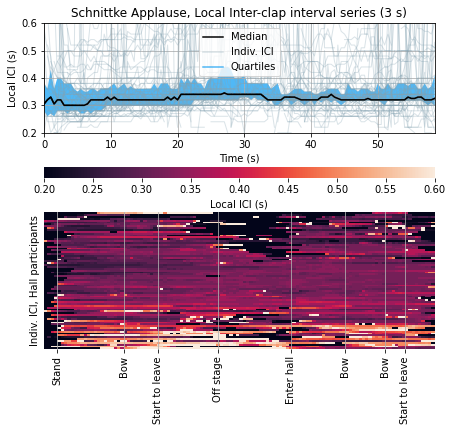

In [498]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]
grid_kws = {"height_ratios": (.4, .04, .5), "hspace": .4}



fig,(a1, cbar_ax, a2) = plt.subplots(3,1,figsize=[7,6],gridspec_kw=grid_kws)

ax = a1
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
l1, = ax.plot(df_feats['Median'],color="black",label='Median')
l2, = ax.plot([0.1,0.1],[0.2,0.2],color='xkcd:bluegrey',alpha=0.3,label='Indiv. ICI')
l3, = ax.plot([0.1,0.1],[0.2,0.2],color='xkcd:azure',alpha=0.7,label='Quartiles')
ax.legend(loc='upper left',handles=[l1, l2, l3],)

df_A.plot(linewidth=1,color='xkcd:bluegrey',alpha=0.3,legend=False,ax = ax)
ax.fill_between(x,y1,y2,facecolor='xkcd:azure',alpha = 0.7)
df_feats.plot(y='Median',color="black",legend=False,ax=ax)

ax.set_ylim([0.2,0.6])
ax.set_xlim([0,58.5])
ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Local ICI (s)')
ax.set_title('Schnittke Applause, Local Inter-clap interval series (3 s)')

ax=a2
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600,cbar_ax=cbar_ax,
                    cbar_kws={"orientation": "horizontal","label":"Local ICI (s)"})
ax.set_ylabel('Indiv. ICI, Hall participants')
subtimes= musician_times.loc[4:13]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()

plt.savefig('./plots/SchnittkeApplause_mixed.png',bbox_inches = 'tight',dpi=300)
plt.show()


# Beethoven applause
Without synchronisation, as far as we can tell

In [100]:
# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
thisround = applause_times.loc[applause_times['Applause_N']==4,:].reset_index(drop=True)
# TIME LABEL
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[1:,'concert_time']-thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values#+25
musician_times['LABEL'] = thisround['Event']
musician_times['Actors'] = thisround['Actor']
musician_times = musician_times.loc[musician_times['Actors'].str.startswith('Musici'),:]
musician_times

cl_start = thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values
cl_end = thisround.loc[thisround['Event']=='Clapping End','concert_time'].values
cl_dur = cl_end - cl_start

In [101]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[3,'files'],index_col=0)
peaks_IDs = peaks.columns
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [102]:
last_claps =df_claps.where(df_claps!=0).last_valid_index()
last_claps

41.64

In [103]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0,cl_dur-t_interval,0.5)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[:5]

<ipython-input-103-b19a98de1eee>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sampletimes = np.arange(0,cl_dur-t_interval,0.5)


,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
0.0,NaN,NaN,0.25,0.32,0.24,NaN,NaN,0.26,0.35,0.34,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,0.22,0.3,NaN
0.5,0.21,NaN,0.25,0.3,0.26,NaN,0.36,0.26,0.3,0.26,...,NaN,0.34,0.26,0.28,NaN,NaN,0.3,0.24,0.26,NaN
1.0,0.21,NaN,0.24,0.3,0.26,0.48,0.36,0.27,0.32,0.32,...,0.29,0.34,0.26,0.28,NaN,NaN,0.3,0.24,0.32,NaN
1.5,0.21,NaN,0.24,0.3,0.27,0.32,0.36,0.27,0.32,0.32,...,0.28,0.34,0.26,0.3,NaN,NaN,0.28,0.24,0.34,1.04
2.0,0.22,NaN,0.24,0.29,0.28,0.3,0.35,0.28,0.32,0.32,...,0.28,0.32,0.32,0.3,0.51,NaN,0.29,0.24,0.35,0.62
2.5,0.23,NaN,0.24,0.28,0.28,0.3,0.35,0.27,0.32,0.29,...,0.28,0.32,0.28,0.3,0.44,NaN,0.32,0.24,0.38,0.24
3.0,0.24,NaN,0.24,0.29,0.28,0.28,0.34,0.24,0.32,0.32,...,0.28,0.32,0.32,0.3,0.42,NaN,0.28,0.25,0.4,0.26
3.5,0.24,NaN,0.24,0.29,0.28,0.28,0.34,0.23,0.32,0.45,...,0.28,0.32,0.3,0.3,0.38,NaN,0.3,0.26,0.42,0.25
4.0,0.26,NaN,0.24,0.29,0.28,0.28,0.34,0.23,0.32,0.58,...,0.28,0.32,0.31,0.3,0.38,NaN,0.28,0.26,0.41,0.25
4.5,0.26,NaN,0.24,0.28,0.29,0.28,0.34,0.25,0.32,0.36,...,0.28,0.32,0.3,0.3,0.33,NaN,0.28,0.26,0.41,0.26


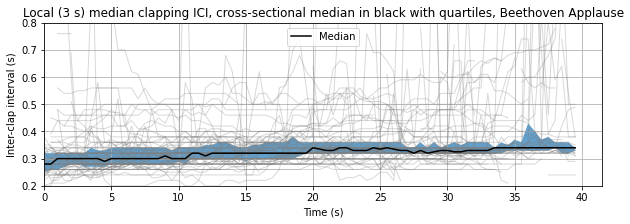

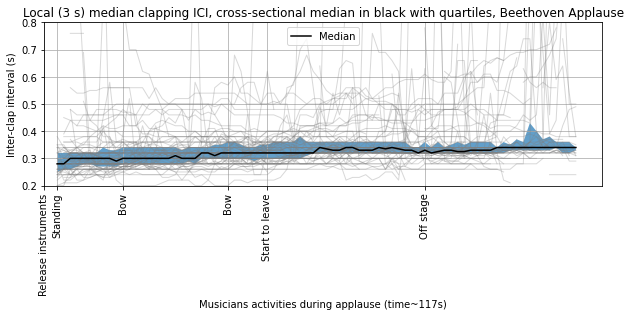

In [104]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Beethoven Applause')
plt.savefig('./plots/BeethovenApplause_Local_ICI_medians_QuartileTS.png',bbox_inches = 'tight',dpi=300)
plt.show()



fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=90)
plt.grid()
plt.xlabel('Musicians activities during applause (time~117s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Beethoven Applause')
plt.savefig('./plots/BeethovenApplause_Local_ICI_medians_QuartileTS_MusEv.png',bbox_inches = 'tight',dpi=300)
plt.show()

81


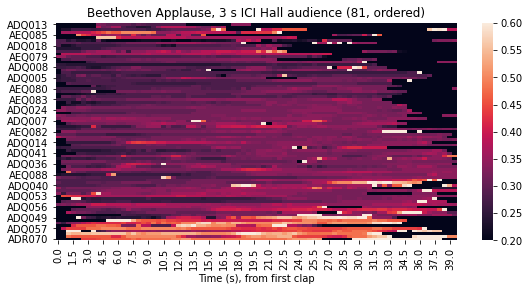

In [105]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#cm = plt.cm.get_cmap('twilight')
# df.filter(like='bbi', axis=0)

feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)
fig, ax = plt.subplots(figsize = [9,4])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Beethoven Applause, 3 s ICI Hall audience (81, ordered)')
plt.xlabel('Time (s), from first clap')
ax.set_xticklabels(np.round(df_A.iloc[ax.get_xticks()].index,2))
plt.savefig('./plots/BeethovenApplause_ICIheatT.png',bbox_inches = 'tight',dpi=300)
plt.show()


81


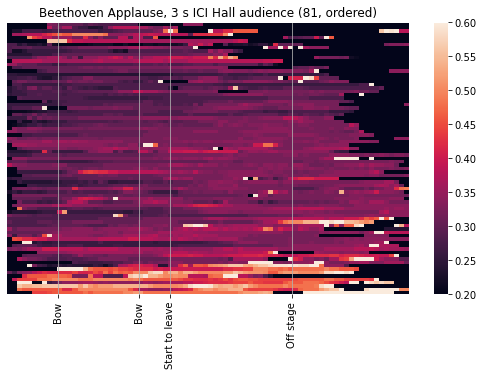

In [106]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#dists = Clap_Feats.sub(Clap_Feats.median(axis=1),axis = 0).sum()
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

fig, ax = plt.subplots(figsize = [9,5])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Beethoven Applause, 3 s ICI Hall audience (81, ordered)')
#plt.xlabel('Time (s), from first clap')
#plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=45,ha='right')
subtimes= musician_times.loc[6:11]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()
plt.savefig('./plots/BeethovenApplause_ICIheatEvents.png',bbox_inches = 'tight',dpi=300)
plt.show()


81


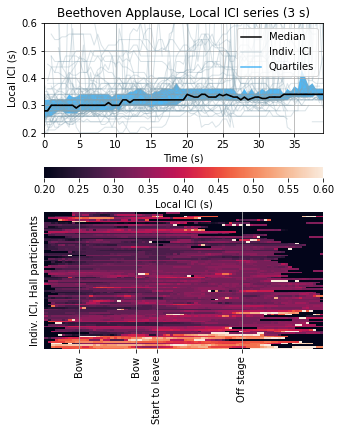

In [107]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]
grid_kws = {"height_ratios": (.4, .04, .5), "hspace": .4}
fig,(a1, cbar_ax, a2) = plt.subplots(3,1,figsize=[5,6],gridspec_kw=grid_kws)# 5,6 40s vs [7,6] for 60s (1 buffer)

ax = a1
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
l1, = ax.plot(df_feats['Median'],color="black",label='Median')
l2, = ax.plot([0.1,0.1],[0.2,0.2],color='xkcd:bluegrey',alpha=0.3,label='Indiv. ICI')
l3, = ax.plot([0.1,0.1],[0.2,0.2],color='xkcd:azure',alpha=0.7,label='Quartiles')
ax.legend(loc='upper left',handles=[l1, l2, l3],)

df_A.plot(linewidth=1,color='xkcd:bluegrey',alpha=0.3,legend=False,ax = ax)
ax.fill_between(x,y1,y2,facecolor='xkcd:azure',alpha = 0.7)
df_feats.plot(y='Median',color="black",legend=False,ax=ax)

ax.set_ylim([0.2,0.6])
ax.set_xlim([0,39.0])
ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Local ICI (s)')
ax.set_title('Beethoven Applause, Local ICI series (3 s)')

ax=a2
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600,cbar_ax=cbar_ax,
                    cbar_kws={"orientation": "horizontal","label":"Local ICI (s)"})
ax.set_ylabel('Indiv. ICI, Hall participants')
subtimes= musician_times.loc[6:11]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()

plt.savefig('./plots/BeethovenApplause_mixed.png',bbox_inches = 'tight',dpi=300)
plt.show()


# TODO 
regenerate the spatial clapping gifs with the re aligned assessement of clapping timing. 

Clapping_final_applause_peaks_ICI_5hz_hist.gif


In [168]:
# claps_folder = 'C:/Users/finnu/dev/copenhagen-musiclab-clapping/clapfiles/clapping_peaks/'
Clap_files = os.listdir(claps_folder+'clapping_peaks/')
clapname = Clap_files[8]
# 6 finale, 14 schnittke, 1 beethoven, 0 bach
print(clapname)

musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
thisround = applause_times.loc[applause_times['Applause_N']==4,:].reset_index(drop=True)
# TIME LABEL
cl_start = thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values
cl_end = thisround.loc[thisround['Event']=='Clapping End','concert_time'].values
cl_dur = cl_end - cl_start
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[4:12,'concert_time']-cl_start
musician_times['LABEL'] = thisround['Event']
musician_times

Applause_4_beethoven_peaks.csv


,TIME,LABEL
4,0.0,Clapping Start
5,0.0,Musicians standing
6,5.0,bow
7,13.0,bow
8,16.0,Start to leave stage
9,19.0,Claps in synch
10,28.0,Off stage
11,31.6,MC starts talking
12,41.5,Clapping End


In [169]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + clapname,index_col=0)
peaks_IDs = peaks.columns
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [170]:
# build database of clapping behaviour over measured intervals
t_interval = 1
sampletimes = np.arange(0,cl_dur-t_interval,0.2)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.iloc[:5]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
0.0,NaN,NaN,0.26,NaN,0.24,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,NaN,0.3,NaN
0.2,NaN,NaN,0.26,NaN,0.24,NaN,NaN,NaN,NaN,0.38,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,NaN,0.3,NaN
0.4,NaN,NaN,0.26,0.32,0.24,NaN,NaN,0.26,0.35,0.34,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,0.25,0.32,NaN
0.6,0.23,NaN,0.25,0.3,0.24,NaN,NaN,0.26,0.32,0.3,...,NaN,NaN,0.26,0.32,NaN,NaN,0.36,0.22,0.3,NaN
0.8,0.2,NaN,0.26,0.3,0.25,NaN,0.36,0.26,0.3,0.26,...,NaN,NaN,0.26,0.32,NaN,NaN,0.36,0.23,0.26,NaN
1.0,0.21,NaN,0.25,0.3,0.26,NaN,0.36,0.26,0.3,0.26,...,NaN,0.34,0.26,0.28,NaN,NaN,0.3,0.24,0.26,NaN
1.2,0.21,NaN,0.25,0.3,0.26,NaN,0.36,0.26,0.32,0.3,...,NaN,0.34,0.26,0.27,NaN,NaN,0.29,0.24,0.32,NaN
1.4,0.22,NaN,0.24,0.3,0.27,NaN,0.36,0.26,0.32,0.26,...,0.29,0.34,0.26,0.28,NaN,NaN,0.29,0.24,0.34,NaN
1.6,0.21,NaN,0.24,0.29,0.28,0.48,0.36,0.27,0.34,0.26,...,0.28,0.34,0.29,0.28,NaN,NaN,0.3,0.24,0.34,NaN
1.8,0.2,NaN,0.24,0.29,0.28,0.32,0.36,0.28,0.34,0.29,...,0.28,0.34,0.26,0.29,NaN,NaN,0.29,0.24,0.34,NaN


In [161]:
from matplotlib import colors
from scipy.spatial.distance import pdist, squareform
import moviepy.editor as mp

In [172]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements

Part_Codes = list(MovingParts.Participant_Code.values)


In [173]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ082,AEQ083,3.0,0,Stranger
566,AEQ082,AEQ087,3.0,0,Stranger
567,AEQ083,AEQ089,3.0,1,Family_ParentChild
568,AEQ084,AER090,3.0,1,Family_ParentChild


In [174]:
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ082,AEQ083,3.0,0,Stranger
566,AEQ082,AEQ087,3.0,0,Stranger
567,AEQ083,AEQ089,3.0,1,Family_ParentChild
568,AEQ084,AER090,3.0,1,Family_ParentChild


In [175]:
Clap_Feats

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
0.0,NaN,NaN,0.26,NaN,0.24,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,NaN,0.3,NaN
0.2,NaN,NaN,0.26,NaN,0.24,NaN,NaN,NaN,NaN,0.38,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,NaN,0.3,NaN
0.4,NaN,NaN,0.26,0.32,0.24,NaN,NaN,0.26,0.35,0.34,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,0.25,0.32,NaN
0.6,0.23,NaN,0.25,0.3,0.24,NaN,NaN,0.26,0.32,0.3,...,NaN,NaN,0.26,0.32,NaN,NaN,0.36,0.22,0.3,NaN
0.8,0.2,NaN,0.26,0.3,0.25,NaN,0.36,0.26,0.3,0.26,...,NaN,NaN,0.26,0.32,NaN,NaN,0.36,0.23,0.26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39.6,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35,NaN,NaN
39.8,NaN,NaN,NaN,0.34,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36,NaN,NaN
40.0,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34,NaN,NaN
40.2,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36,NaN,NaN


In [176]:
ClapDets=partDets.loc[partDets['Participant_Code'].isin(Clap_Feats.columns),:]
#Clap_Feats = Clap_Feats[ClapDets['Participant_Code']]
Clap_Feats.fillna(0,inplace = True)
#Clap_Feats

In [148]:
clapname[:-10]

'Applause_4_beethoven'

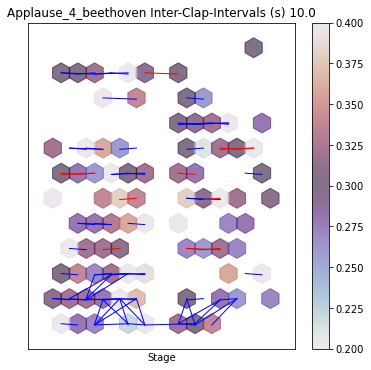

In [177]:
i = 50
plt.figure(figsize=[6,6])
plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values, cmap='twilight', vmin=0.2, vmax=0.4, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
cbar = plt.colorbar()

# now add the relationships Friends
Friends = Near_Rels[Near_Rels['Relationship'].str.contains('Friend')]
Friends
for i,ship in Friends.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'b',linewidth = 1)

Family = Near_Rels[Near_Rels['Relationship'].str.contains('Family')]
Family
for i,ship in Family.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'r',linewidth = 1)


# cbar.solids.set_edgecolor("face")
# plt.draw()
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

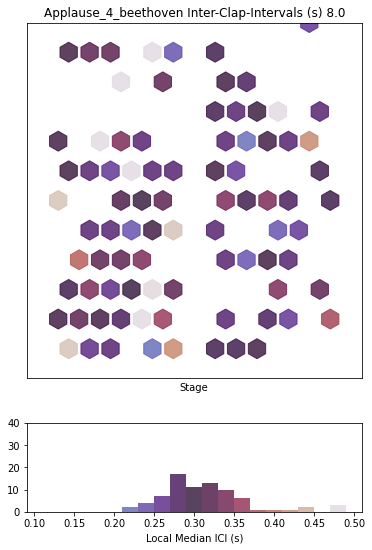

In [178]:
slice_i = 40
vmin=0.11
vmax=0.51
bins = np.arange(vmin,vmax,0.02)
colours = 'twilight'
cm = plt.cm.get_cmap(colours)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()
col = bin_centers - min(bin_centers)
col /= max(col)

fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.8)
ax[0].set_xlim([-8,8])
ax[0].set_ylim([0,12])
# ax[0].set_xlim([-7,7])
# ax[0].set_ylim([0.5,12.5])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('Stage')
ax[0].set_title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

# N is the count in each bin, bins is the lower-limit of the bin
n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.8)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax[1].set_xlabel('Local Median ICI (s)')
ax[1].set_ylim([0,40])
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

In [179]:
# generate gif with this 
filenames = []
for i in range(len(Clap_Feats)):
    # plot the line chart
    plt.figure(figsize=[6,6])
    plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values,  cmap='twilight', vmin=0.2, vmax=0.5, s=400, marker="h", alpha=0.6)
    plt.xlim([-8,8])
    plt.ylim([0,13])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Stage')
    plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
    cbar = plt.colorbar()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
# build gif
gif_path = './plots/Clapping_'+clapname[:-10]+'_ICI_5x5hz.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [166]:
filename

'78.png'

In [181]:
range(1,len(Clap_Feats))

range(1, 203)

In [193]:
# generate gif with this 
filenames = []
vmin=0.11
vmax=0.51
bins = np.arange(vmin,vmax,0.02)
colours = 'twilight'
cm = plt.cm.get_cmap(colours)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()
col = bin_centers - min(bin_centers)
col /= max(col)

slice_i = 0

fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.6)
ax[0].set_xlim([-8,8])
ax[0].set_ylim([0,12])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel('Audience')
ax[0].set_xlabel('Stage')
ax[0].set_title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

# N is the count in each bin, bins is the lower-limit of the bin
n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.6)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax[1].set_xlabel('Local Median ICI (s)')
ax[1].set_ylim([0,40])
ax[1].set_title('Distribution of ICI at ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))
# create file name and append it to a list
filename = f'{slice_i}.png'
filenames.append(filename)
filenames.append(filename)

# save frame
plt.savefig(filename,bbox_inches = 'tight',dpi=200)
plt.close()

for slice_i in range(1,len(Clap_Feats)):
    fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

    ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.6)
    ax[0].set_xlim([-8,8])
    ax[0].set_ylim([0,12])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_ylabel('Audience')
    ax[0].set_xlabel('Stage')
    ax[0].set_title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

    # N is the count in each bin, bins is the lower-limit of the bin
    n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.6)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    ax[1].set_xlabel('Local Median ICI (s)')
    ax[1].set_ylim([0,40])
    ax[1].set_title('Distribution of ICI at ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))
    # create file name and append it to a list
    filename = f'{slice_i}.png'
    filenames.append(filename)
    filenames.append(filename)
    # save frame
    plt.savefig(filename,bbox_inches = 'tight',dpi=200)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)

# build gif
gif_path = './plots/Clapping_'+clapname[:-4]+'_ICI_5hz_hist.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

#### mov or audio 

https://pythonbasics.org/python-play-sound/


https://pythonprogramming.altervista.org/animated-cartoon-gif-with-pil-and-python-1/?doing_wp_cron=1673647035.3732910156250000000000

https://www.thepythoncode.com/article/add-audio-to-video-in-python

https://stackoverflow.com/questions/48728145/video-editing-with-python-adding-a-background-music-to-a-video-with-sound



In [191]:
from pydub import AudioSegment
from pydub.playback import play

song = AudioSegment.from_wav("sound/beethoven_claps.wav")
play(song)

In [194]:
outfile = './plots/Clapping_Applause_4_beethoven_peaks_ICI_5hz_hist.gif'
clip = mp.VideoFileClip(outfile)
clip.write_videofile("myvideo.mp4")

t:   2%|▏         | 10/411 [00:00<00:04, 94.16it/s, now=None]

Moviepy - Building video myvideo.mp4.
Moviepy - Writing video myvideo.mp4



Moviepy - Done !
Moviepy - video ready myvideo.mp4


In [204]:
import moviepy.editor as mp

audio = mp.AudioFileClip("beethoven_claps.mp3")
video1 = mp.VideoFileClip('myvideo.mp4')
final = video1.set_audio(audio)

final.write_videofile("output.mp4")

chunk:  13%|█▎        | 121/916 [00:00<00:00, 1202.28it/s, now=None]

Moviepy - Building video output.mp4.
MoviePy - Writing audio in outputTEMP_MPY_wvf_snd.mp3


t:   3%|▎         | 11/411 [00:00<00:03, 105.33it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [205]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination'

# CLAIMS 

### asynchronous clapping is a voluntary active strategic behaviour, to maintain shycnrhony, and shift to synchrony in clapping is a deliberate change of strategy by audience, not an immergent behaviour.

We maintain texture of independent clapping when we want to.

Nothing intevitable about synchrony. 
    something voluntary and strategic about synch
        ex partial synch
        
        
### clapping behaviour individually related to who they are and why they are there
beahviour features: regularity, time of first clap, relative duration of clapping
clapper features: musical expertise, age, awe or KM?

### Emmergence of Synchronisation
Synchronisation is a choice that people can resist. the rate of accumulation via instantaneous ICI rates (is it worth increasing the alignment to track this more smoothly? just in finale?)